In [1]:
import h5py
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import trange
from sklearn.decomposition import PCA
from aging.plotting import figure, format_plots, legend
from scipy.spatial.distance import pdist, squareform

In [2]:
format_plots()

In [3]:
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_05/longtogeny_males_clean.parquet')
# df = df[df.index.get_level_values('age') < 600]
ages = df.index.get_level_values('age')

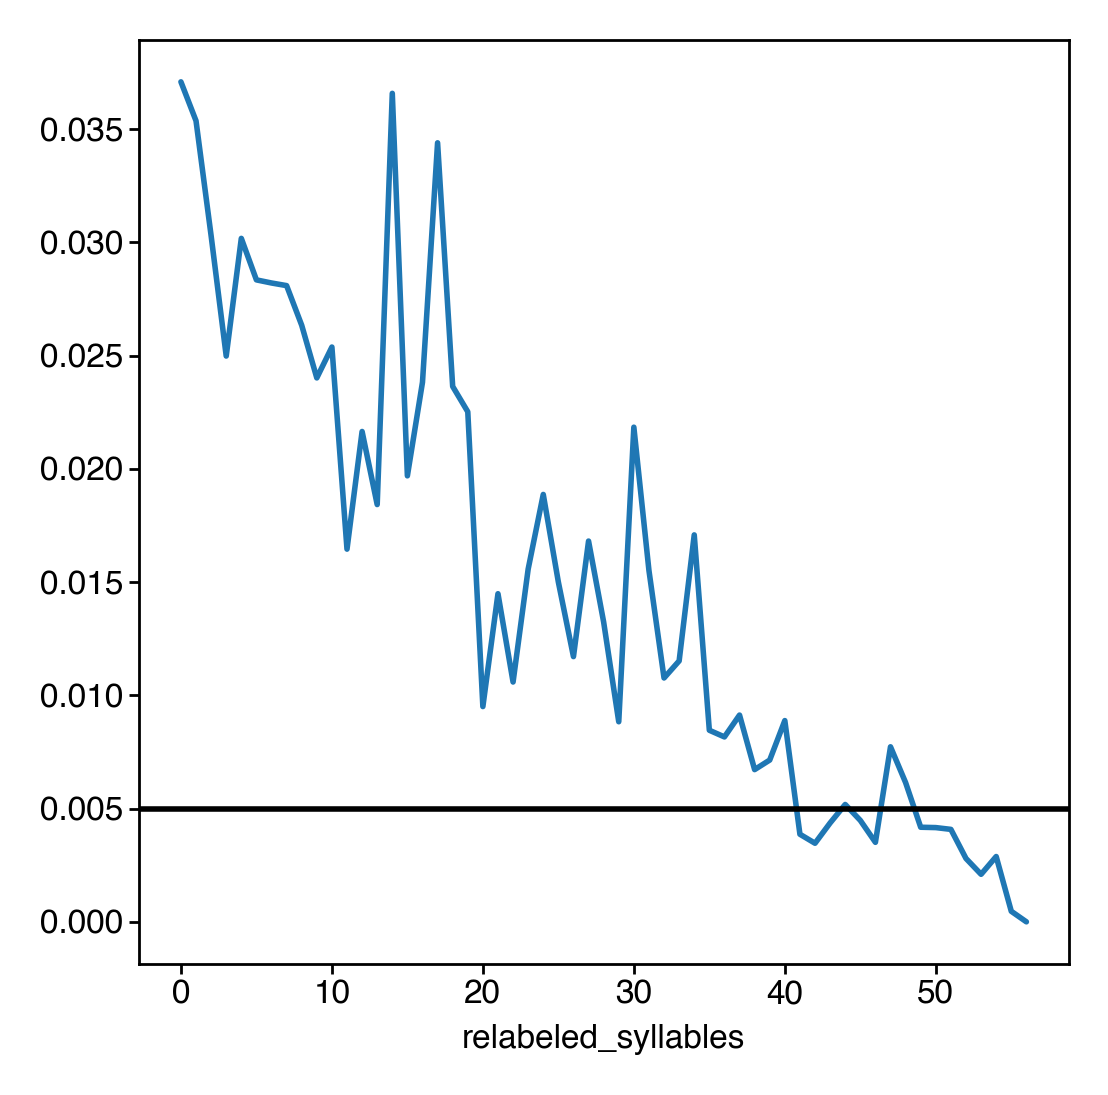

In [4]:
df.median().plot()
plt.axhline(0.005, color='k')

In [5]:
keep_sylls = df.median() > 0.01

In [6]:
exclude_dates = [pd.Timestamp('2021-10-16 17:00:57')]

In [7]:
df = df[~df.index.get_level_values('date').isin(exclude_dates)]

In [8]:
session_exclusion_list = '/n/groups/datta/win/longtogeny/data/metadata/Ontogeny experiment list - Session quality control.csv'
exclusion_df = pd.read_csv(session_exclusion_list, header=0)

exclusion_df['Keep?'] = exclusion_df['Keep?'].str.lower()
exclusions = exclusion_df.query('`Keep?` != "y"')
exclusion_df['Keep?'].unique()

array(['y', 'n', '?'], dtype=object)

In [9]:
exclusions.head()

File path Checked? Keep?  \
3  /n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...        y     n   
4  /n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...        y     n   
5  /n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...        y     n   
6  /n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...        y     n   
7  /n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...        y     n   

                                      Issue  
3  fading, noise, further inspection needed  
4                                     noise  
5                                wall noise  
6                       replaced with noise  
7                                wall noise

In [10]:
exclude_uuid = []
for idx, row in exclusions.iterrows():
    with h5py.File(row['File path'], 'r') as h5f:
        uuid = h5f['metadata/uuid'][()].decode()
        exclude_uuid.append(uuid)

In [11]:
mask = ~df.index.get_level_values('uuid').isin(exclude_uuid)

In [12]:
df = df[mask]

In [13]:
outliers = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_05/male_long_outlier_sessions.parquet')

outlier_uuids = outliers.index.get_level_values('uuid')

In [14]:
df = df[~df.index.get_level_values('uuid').isin(outlier_uuids)]

In [15]:
norm_df = np.log(df + 1e-6)

In [16]:
def zscore(arr):
    return (arr - np.mean(arr, axis=0, keepdims=True)) / np.std(arr, axis=0, keepdims=True)

In [17]:
pca = PCA()
pcs = zscore(pca.fit_transform(df)[:, :14])

In [18]:
np.sum(np.cumsum(pca.explained_variance_ratio_) < 0.9)

14

In [19]:
# distances = squareform(pdist(df.loc[:, keep_sylls].to_numpy(), metric="jensenshannon"))
distances = squareform(pdist(zscore(df.loc[:, keep_sylls].to_numpy()), metric="euclidean"))
# distances = squareform(pdist(pcs, metric="euclidean"))
nn = np.argsort(distances, axis=1)

In [20]:
# plt.imshow(distances)

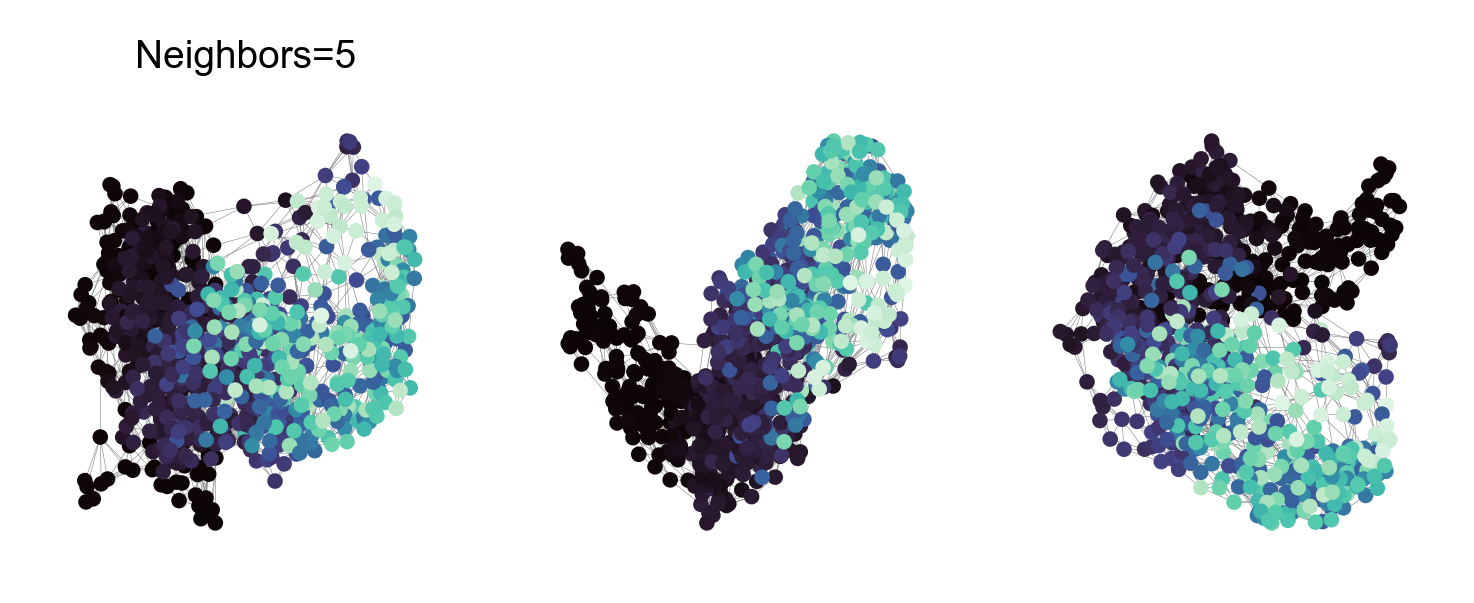

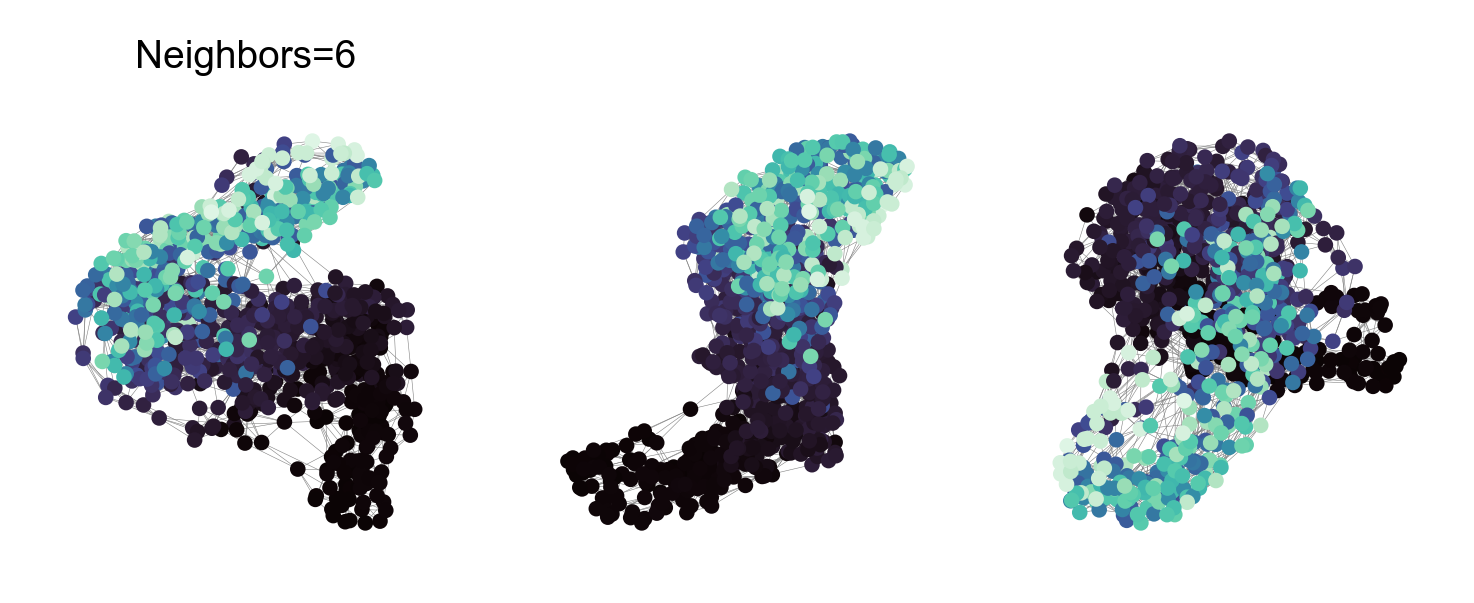

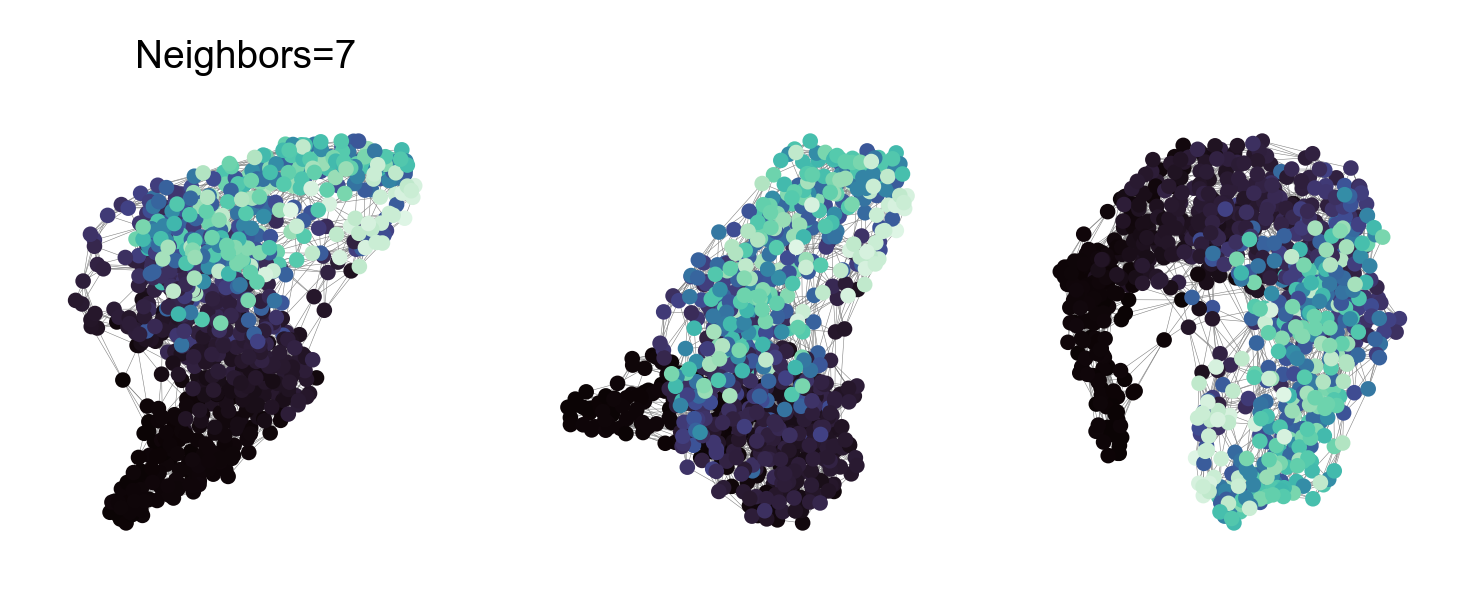

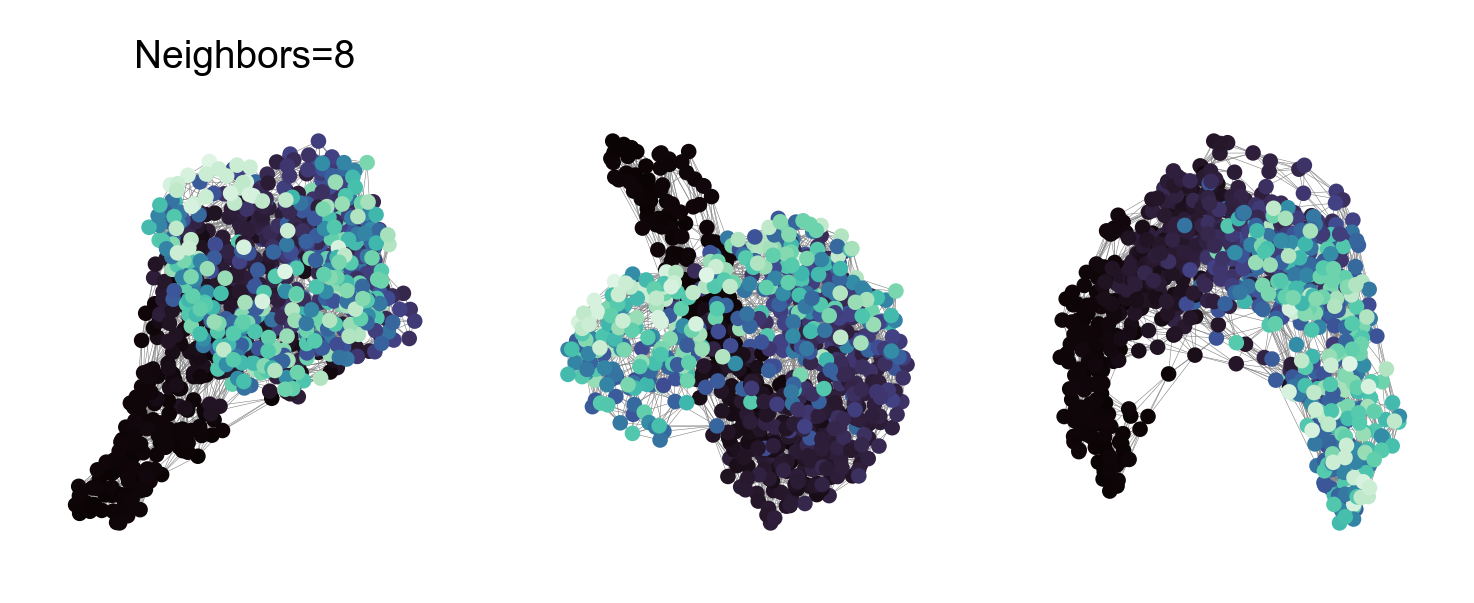

KeyboardInterrupt: 

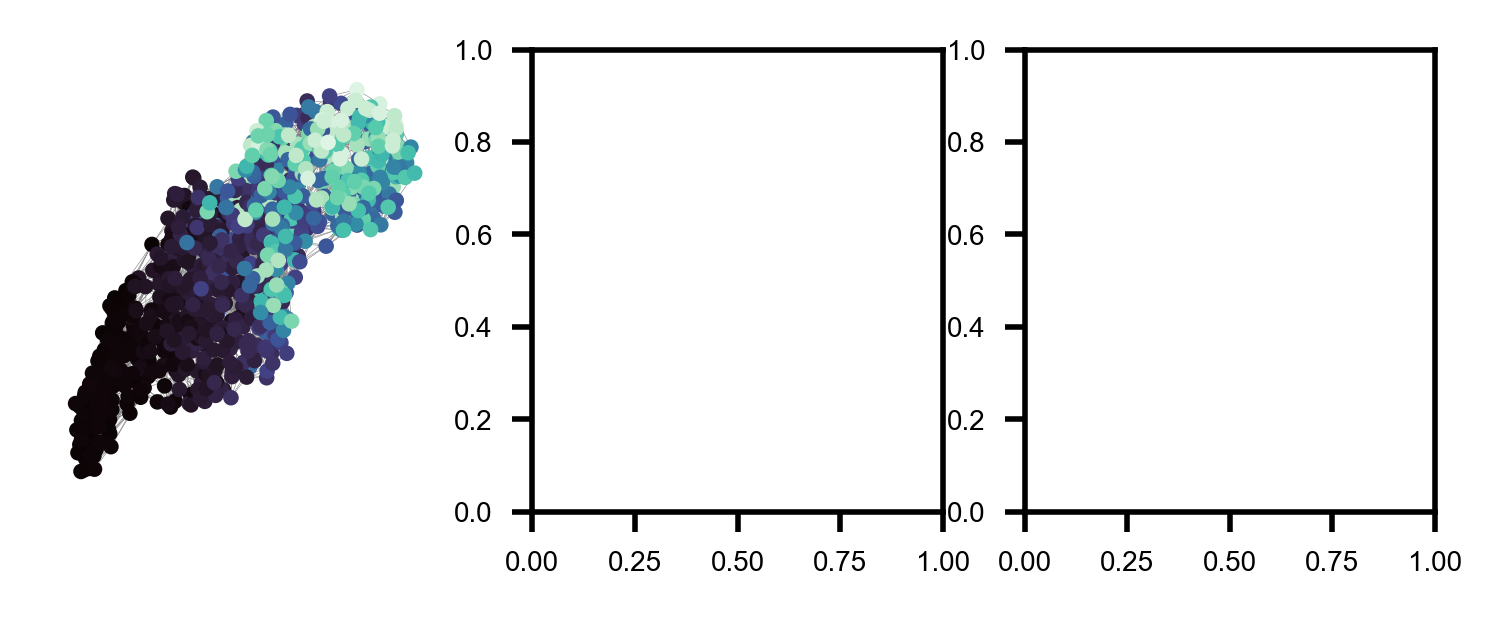

In [22]:
width = 1.5
n_cols = 3
# for k_neigh in [9]:
for k_neigh in range(5, 20):
    indices = nn[:, :k_neigh + 1]

    graph = nx.Graph()
    edges = []
    for row in indices:
        i = row[0]
        for j in row[1:]:
            edges.append((i, j, distances[i, j]))
            # edges.append((i, j))
    graph.add_weighted_edges_from(edges)
    # graph.add_edges_from(edges)
    colors = [ages[i] for i in graph.nodes]

    fig, ax = plt.subplots(1, n_cols, figsize=(n_cols * width, 1.5))
    for i, a in enumerate(ax.flat):
        pos = nx.spring_layout(graph, seed=i)
        nx.draw(
            graph,
            pos=pos,
            node_size=4,
            width=0.1,
            edge_color="gray",
            node_color=colors,
            arrows=False,
            ax=a,
            cmap="mako",
        )
    ax[0].set(title=f"Neighbors={k_neigh}")
    plt.show()

[Text(0.5, 1.0, 'Time of day')]

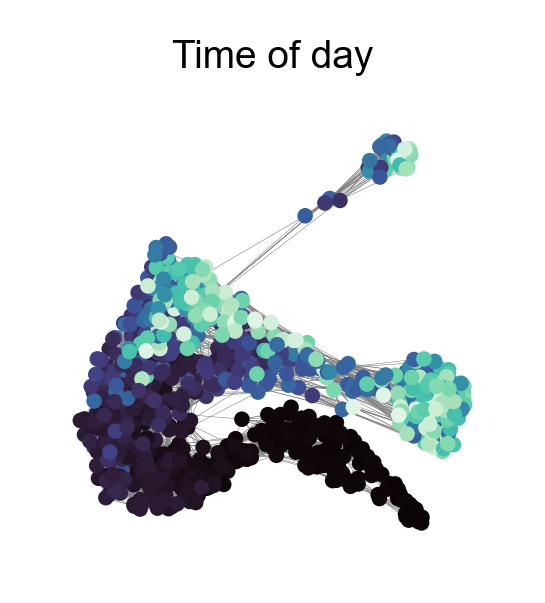

In [136]:
# find the "outliers"
k_neigh = 8
indices = nn[:, :k_neigh + 1]

graph = nx.DiGraph()
edges = []
for row in indices:
    i = row[0]
    for j in row[1:]:
        edges.append((i, j, distances[i, j]))
graph.add_weighted_edges_from(edges)
colors = [ages[i] for i in graph.nodes]

fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))
for i, a in enumerate([ax]):
    pos = nx.spring_layout(graph, seed=i)
    nx.draw(
        graph,
        pos=pos,
        node_size=4,
        width=0.1,
        edge_color="gray",
        node_color=colors,
        arrows=False,
        ax=a,
        cmap="mako",
    )
ax.set(title="Time of day")

[Text(0.5, 1.0, 'Time of day')]

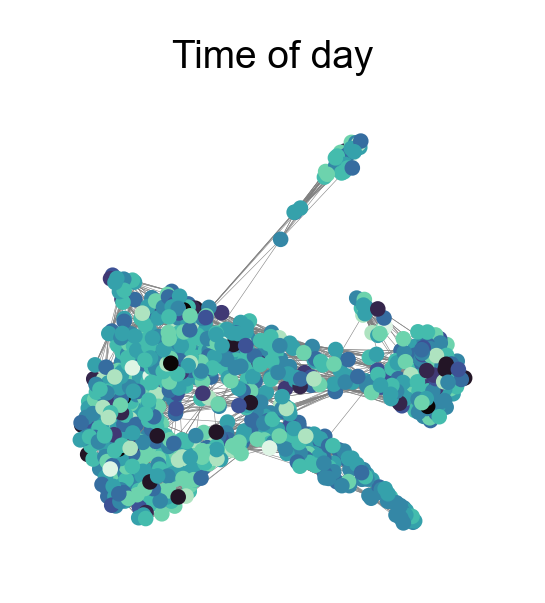

In [34]:
dates = df.index.get_level_values('date')
tod = pd.Series(dates).dt.hour

# find the "outliers"
k_neigh = 8
indices = nn[:, : k_neigh + 1]

graph = nx.DiGraph()
edges = []
for row in indices:
    i = row[0]
    for j in row[1:]:
        edges.append((i, j, distances[i, j]))
graph.add_weighted_edges_from(edges)
colors = [tod.iloc[i] for i in graph.nodes]

fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))
for i, a in enumerate([ax]):
    pos = nx.spring_layout(graph, seed=i)
    nx.draw(
        graph,
        pos=pos,
        node_size=4,
        width=0.1,
        edge_color="gray",
        node_color=colors,
        arrows=False,
        ax=a,
        cmap="mako",
    )
ax.set(title="Time of day")

In [137]:
m = np.argsort([v[1] for v in pos.values()])[::-1]

In [138]:
np.array(list(pos))[m[0]]

690

In [139]:
pos_arr = np.array([pos[i] for i in np.arange(len(distances))])

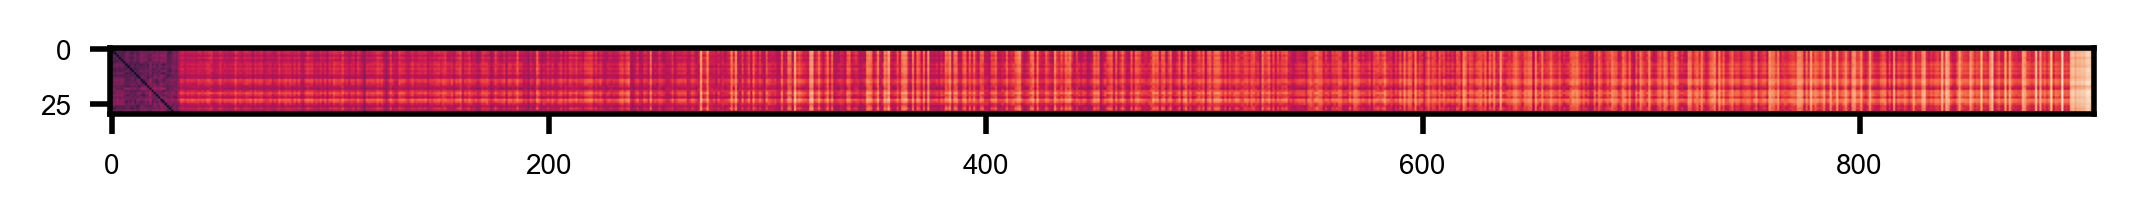

In [143]:
plt.imshow(distances[m2[:30]][:, m2])

In [144]:
df.iloc[m2[:32]].sort_index(level='date')

relabeled_syllables                                                                         0   \
age mouse cage uuid                                 subject_name date                            
128 04_01 04   7444cf90-528f-4f11-8e6a-8dc721452e7f 04_01_070    2021-07-15 16:20:14  0.016987   
135 04_01 04   5266972e-6a3e-42b0-aeca-6c94590af4ce 04_01_071    2021-07-22 17:57:53  0.020141   
143 04_01 04   365f551e-fca3-4e8a-a4a2-d25d9141aeb5 04_01_80     2021-07-30 16:12:11  0.019598   
149 04_01 04   ba31b191-b934-4ac8-89ac-3190ef4cb79d 04_01_085    2021-08-05 15:56:22  0.018618   
157 04_01 04   5522a8d6-9be4-4649-b348-ba48b4a7d269 04_01_089    2021-08-13 17:29:22  0.019307   
165 04_01 04   a7180aa3-f107-4a11-9b25-8aaf174317c5 04_01_090    2021-08-21 20:02:11  0.017857   
183 04_01 04   051510d1-1c8b-4f40-b982-c1908bc5a544 04_01_099    2021-09-08 16:39:18  0.023020   
194 04_01 04   2deb4147-4d07-457d-91bf-018150f9c8c9 04_01_100    2021-09-19 14:33:26  0.015873   
199 04_01 04   5d109d17-5143-4eae-91b1-36059b1bfa8c 04_01_101    2021-09-24 17:21:07  0.025700   
206 04_01 04   486d347c-c5d9-48f3-994b-fef0e58d5cc8 04_01_102    2021-10-01 15:18:30  0.032241   
215 04_01 04   9639f5b4-1a03-481b-a7ca-5df78b18f0a8 04_01_103    2021-10-10 14:41:52  0.027299   
221 04_01 04   4babacfa-2bfb-4073-9a6e-0f546f526791 04_01_104    2021-10-16 17:26:14  0.031177   
228 04_01 04   ee115e17-eb86-44a5-b9ad-52359e541b82 04_01_105    2021-10-23 17:52:25  0.015138   
243 04_01 04   f41f3aa2-fdd9-4f64-b4ac-881591137b8a 04_01_110    2021-11-07 18:10:29  0.027532   
250 04_01 04   c0a41205-d0ac-4d4b-9140-baca53c943c5 04_01_120    2021-11-14 17:49:06  0.032803   
270 04_01 04   b91a7d3f-9328-4fb2-aaf1-d4f9dd5a8811 04_01_200    2021-12-04 17:55:07  0.027252   
285 04_01 04   2d2d1ee1-434c-4601-83a5-01f23e6b516f 04_01_300    2021-12-19 18:07:22  0.031396   
354 04_01 04   758b1ab1-efc4-4408-8082-1eb4b1b49134 04_01_200    2022-02-26 18:58:39  0.026764   
360 04_01 04   f5d16cda-134c-4154-a503-48bb59aefea9 04_01_201    2022-03-04 16:55:32  0.033414   
376 04_01 04   44ed6e18-4c6f-4488-aedb-58a8158d29df 04_01_203    2022-03-20 20:18:15  0.019273   
385 04_01 04   74eb1ad6-f8bf-4866-ad0d-ebec6894c5ca 04_01_205    2022-03-29 18:44:44  0.030812   
395 04_01 04   2411d3a3-4335-4388-bec9-394fadf993a3 04_01_206    2022-04-08 18:43:36  0.025615   
404 04_01 04   89caf575-c504-4765-a549-a9765b4c90a5 04_01_207    2022-04-17 15:37:40  0.028087   
411 04_01 04   8e2f50d4-9f49-4ddc-9808-6a65051c8080 04_01_208    2022-04-24 14:23:06  0.031579   
418 04_01 04   638ba1ad-6376-49f5-91ce-c8b40eee5f18 04_01_209    2022-05-01 15:42:35  0.020000   
431 04_01 04   1029413a-cc00-4f91-8378-69363c21d378 04_01_210    2022-05-14 19:00:56  0.021567   
439 04_01 04   f00b2496-18b0-466c-972b-0496d2f764e1 04_01_211    2022-05-22 18:08:43  0.012417   
449 04_01 04   cb317985-8a95-4783-99b3-3a9a5cf18f1d 04_01_212    2022-06-01 14:03:18  0.013520   
460 04_01 04   84744512-bf09-414d-8976-861b6a8c757b 04_01_213    2022-06-12 16:42:01  0.022696   
468 04_01 04   1311a5cd-50d2-422f-b771-d50f50455f31 04_01_214    2022-06-20 11:21:12  0.029060   
488 04_01 04   8abb9c62-28e8-436b-9c70-19b7abd15f61 04_01_216    2022-07-10 16:59:37  0.027803   
492 04_01 04   d4331f3b-63de-4a14-a23f-201999bf63f7 04_01_217    2022-07-14 17:08:06  0.024639   

relabeled_syllables                                                                         1   \
age mouse cage uuid                                 subject_name date                            
128 04_01 04   7444cf90-528f-4f11-8e6a-8dc721452e7f 04_01_070    2021-07-15 16:20:14  0.024586   
135 04_01 04   5266972e-6a3e-42b0-aeca-6c94590af4ce 04_01_071    2021-07-22 17:57:53  0.018267   
143 04_01 04   365f551e-fca3-4e8a-a4a2-d25d9141aeb5 04_01_80     2021-07-30 16:12:11  0.018128   
149 04_01 04   ba31b191-b934-4ac8-89ac-3190ef4cb79d 04_01_085    2021-08-05 15:56:22  0.008329   
157 04_01 04   5522a8d6-9be4-4649-b348-ba48b4a7d269 04_01_089    2021-08-13 17:

In [ ]:
# df.iloc[m2[:32]].sort_index(level='date').to_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_05/male_long_outlier_sessions.parquet')

## Run pseudotime diffusion

In [20]:
from scipy.stats import spearmanr, rankdata
from sklearn.preprocessing import LabelEncoder
import colorcet as cc

In [21]:
def mm_norm(x):
    return (x - x.min()) / np.ptp(x)

In [22]:
k_neigh = 6

a = np.zeros_like(distances)
a[np.arange(len(a))[:, None], nn[:, :k_neigh + 1]] = 1 / k_neigh

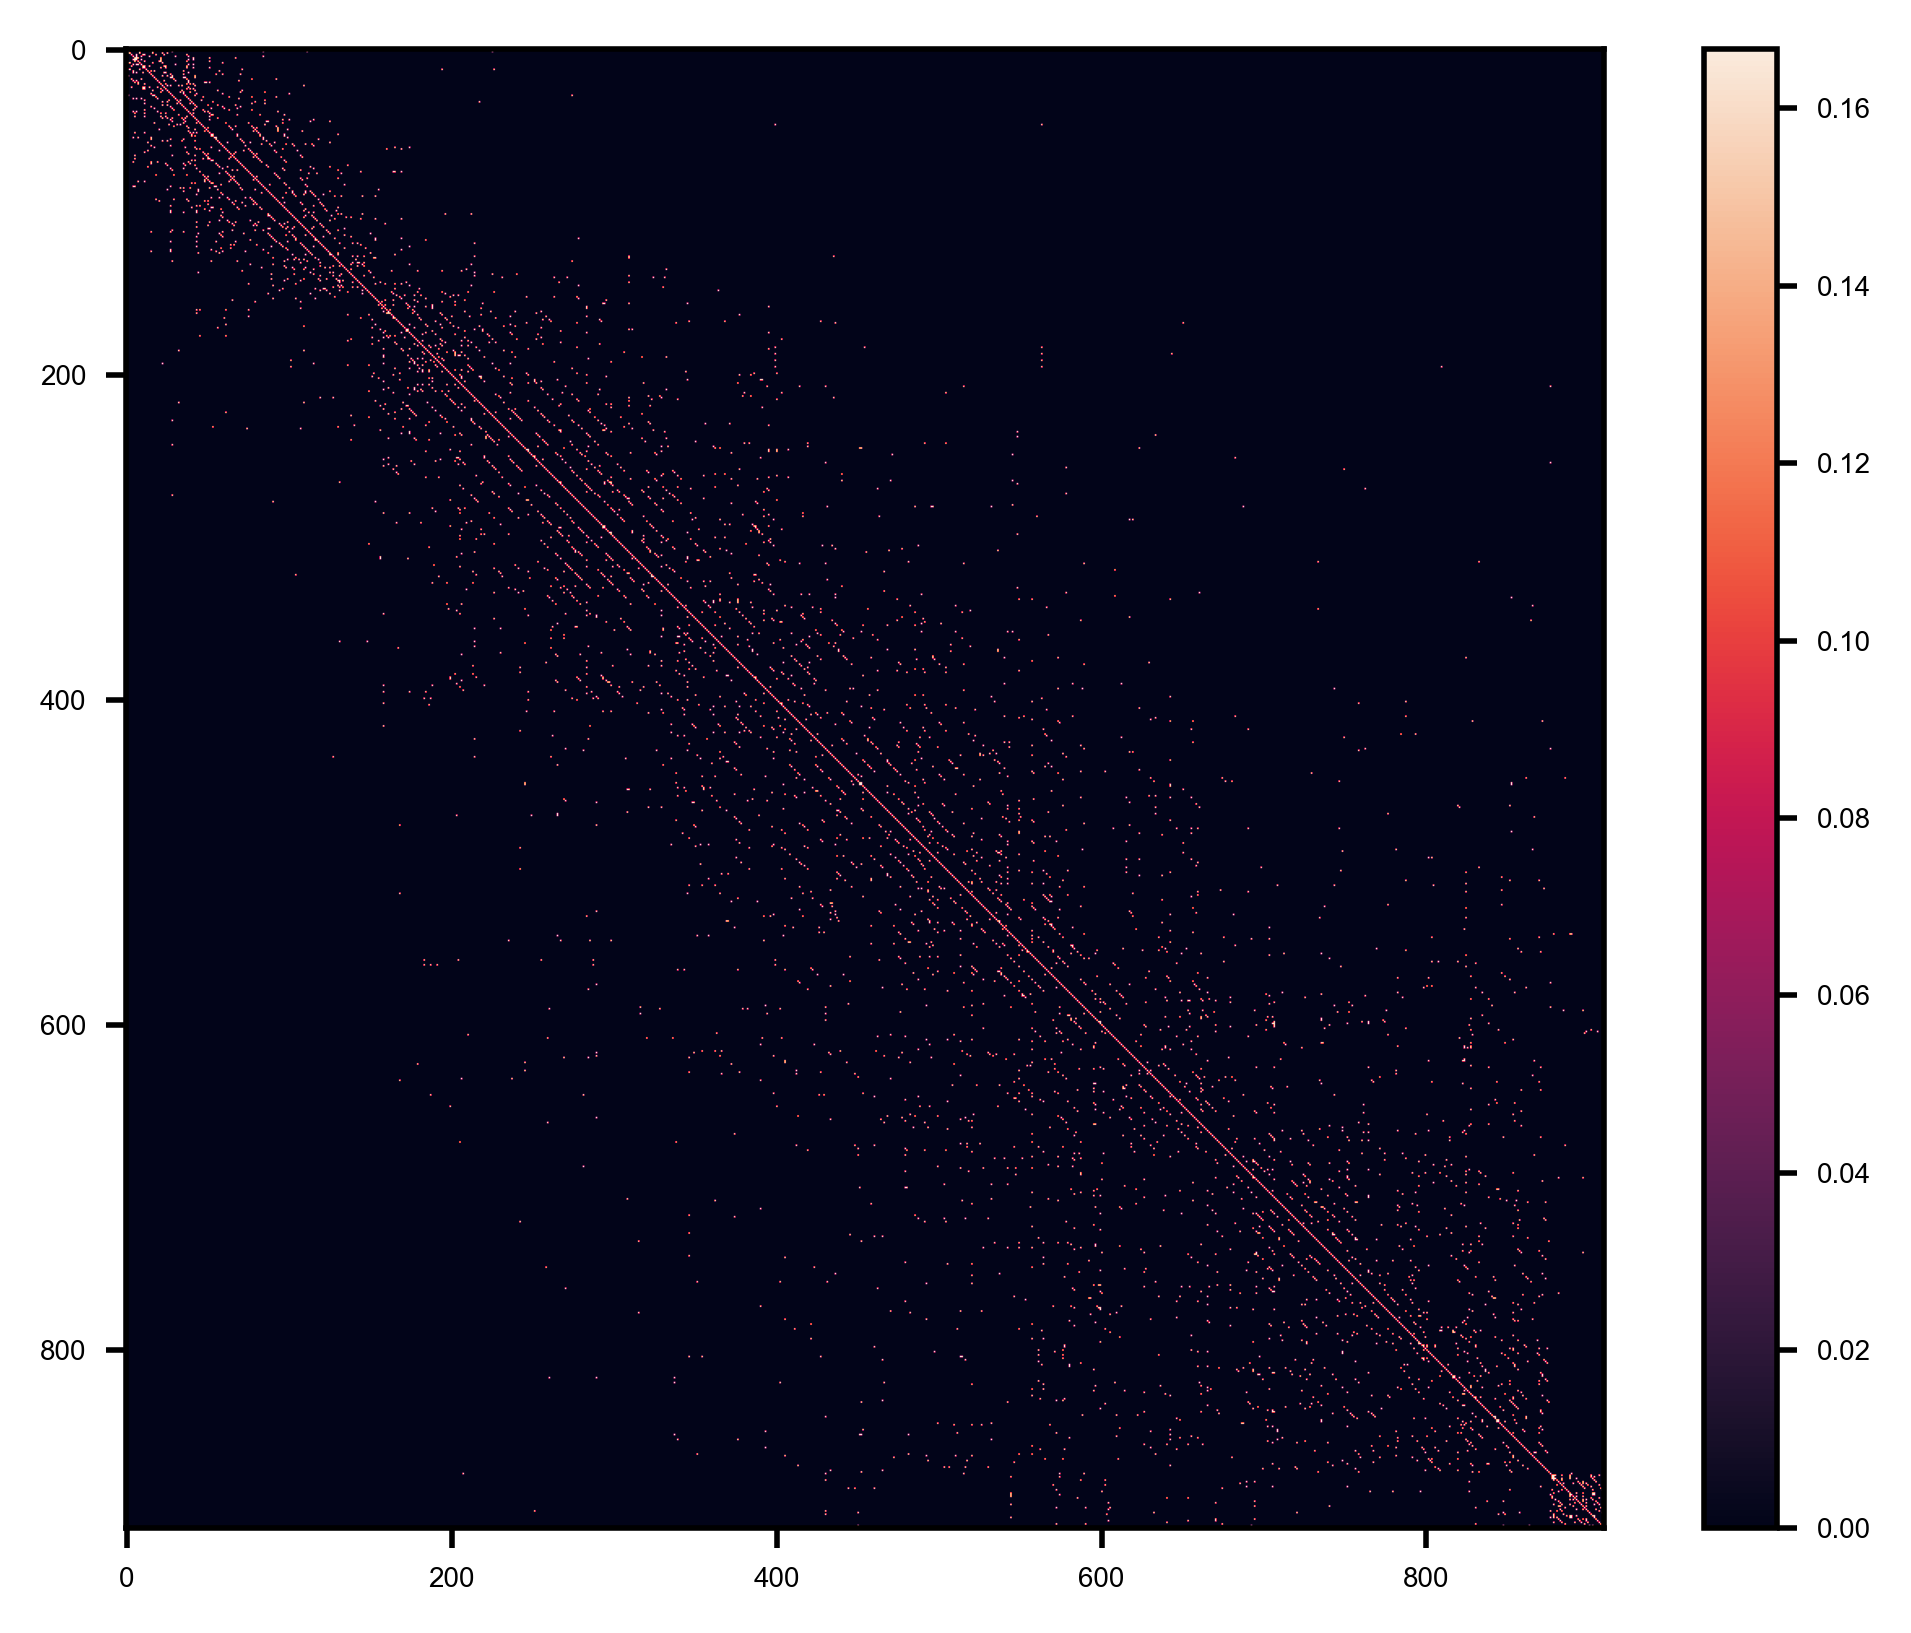

In [23]:
plt.imshow(a)
plt.colorbar()

In [24]:
beta = 0.1
smoother = np.eye(len(a)) * beta * a + (1 - beta) * a

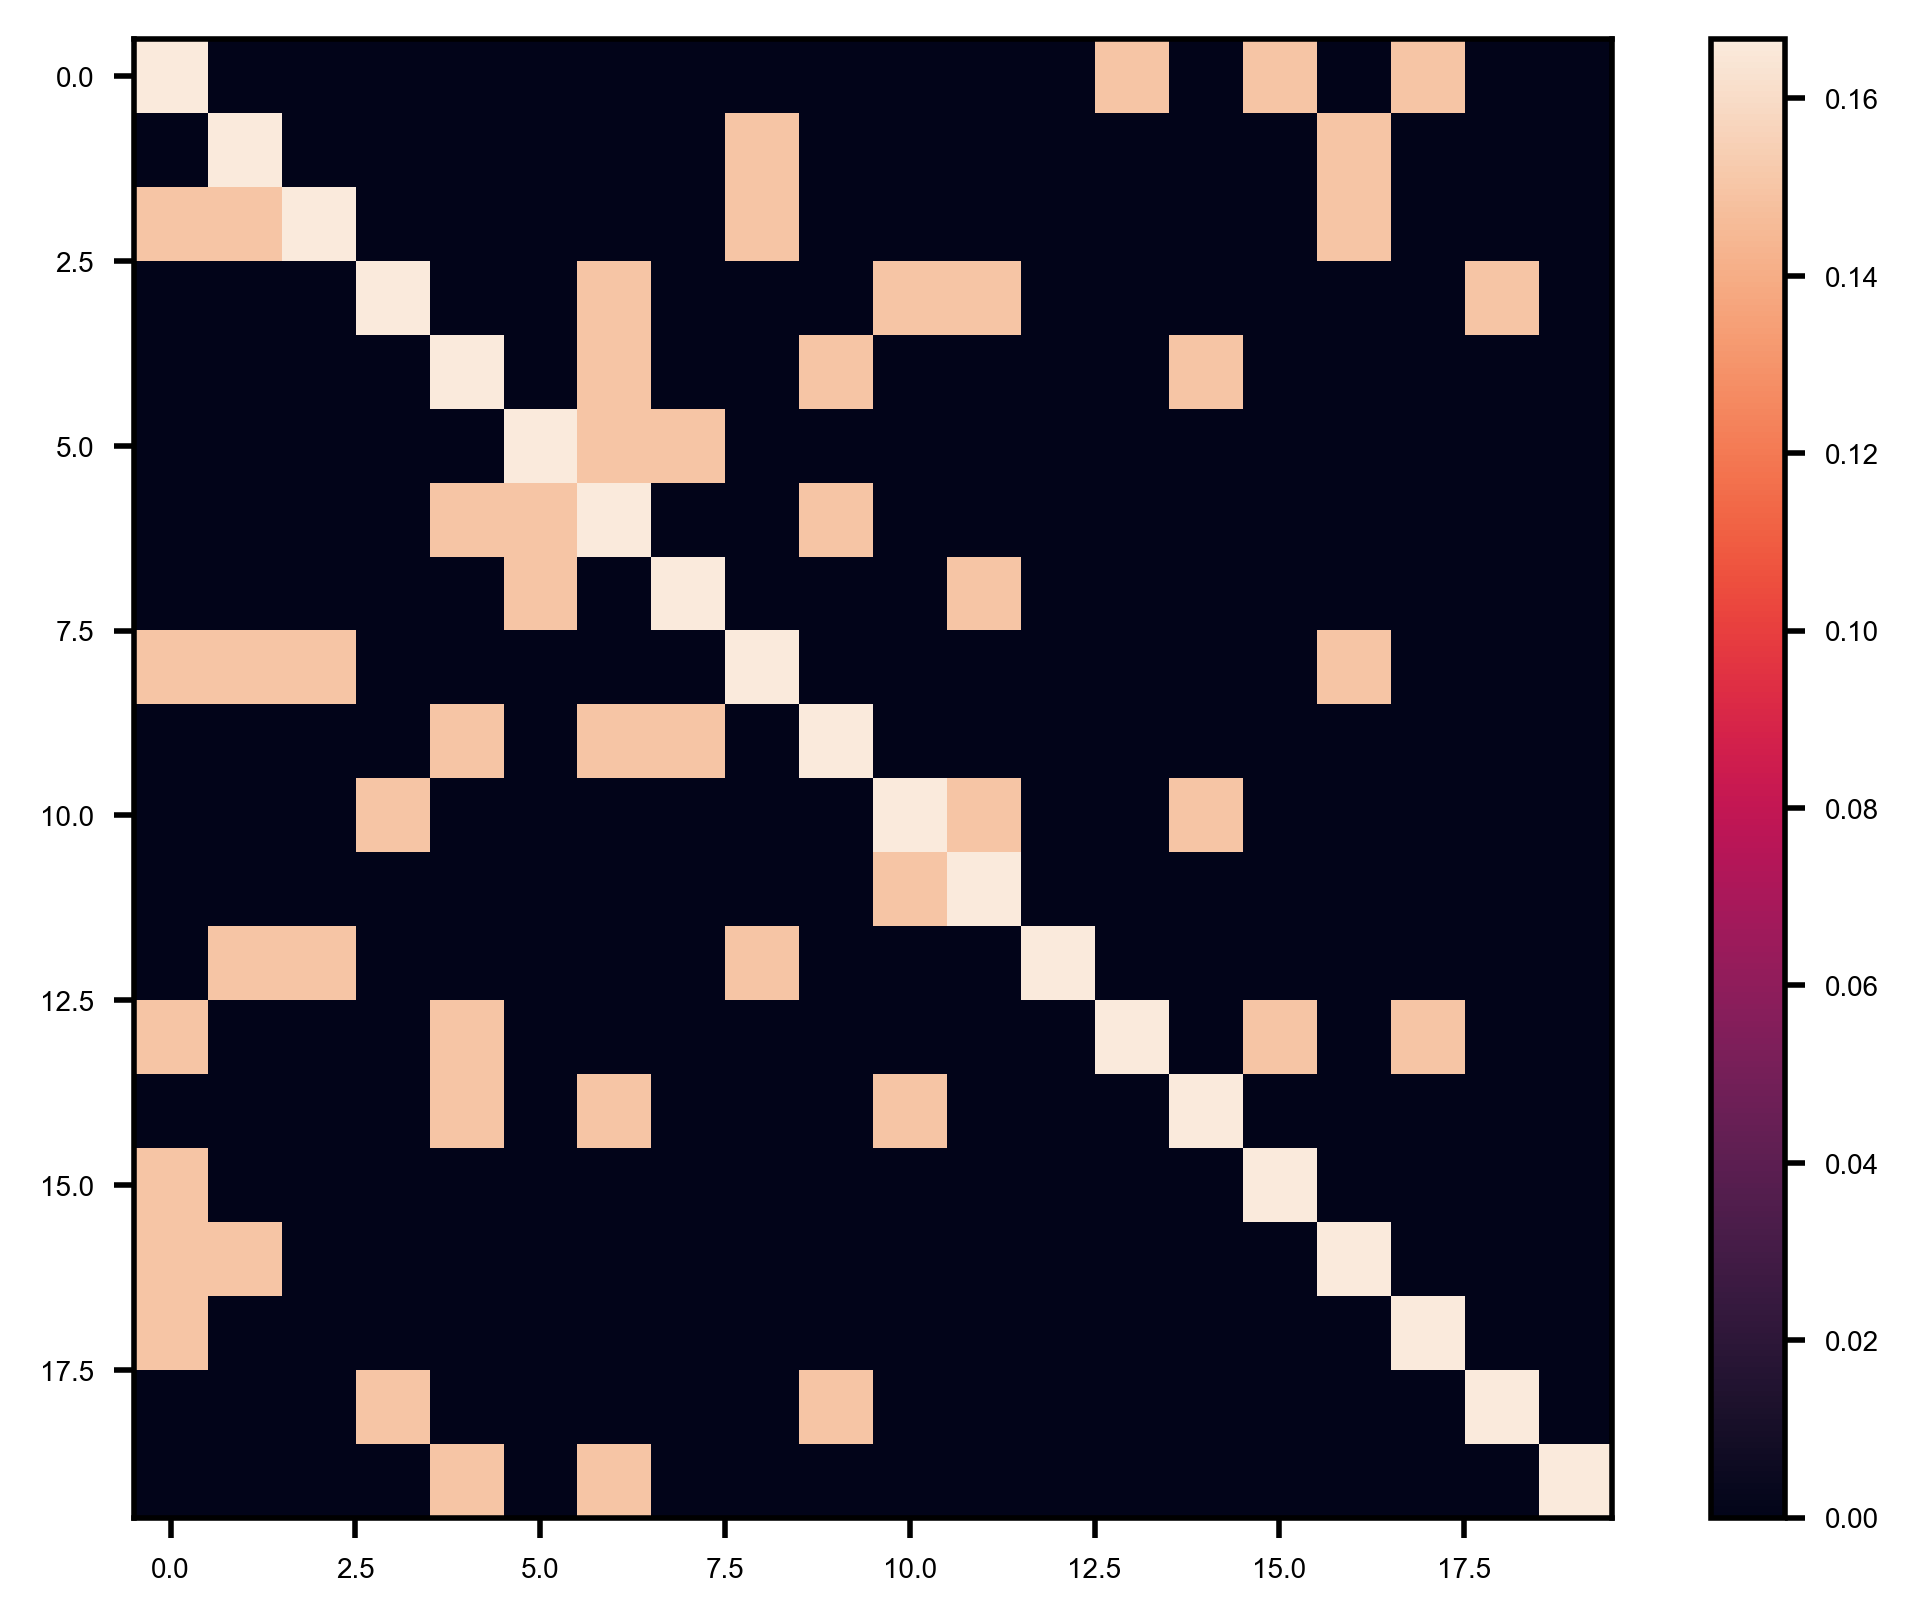

In [25]:
plt.imshow(smoother[:20, :20], interpolation='none')
plt.colorbar()

In [26]:
seed_idx = np.where(df.index.get_level_values('age') == df.index.get_level_values('age').min())[0]

In [27]:
_age = df.index.get_level_values('age').to_numpy()
_age = (_age - _age.min()) / np.ptp(_age)

In [28]:
# pseudo_vals = np.zeros(len(a))
# pseudo_vals[seed_idx] = 1
pseudo_vals = 1 - _age.copy()

n_iter = 5_000
out = np.zeros((len(a), n_iter))

out[:, 0] = pseudo_vals
for i in trange(1, n_iter):
    out[:, i] = mm_norm(smoother @ out[:, i-1])

  0%|          | 0/4999 [00:00<?, ?it/s]

In [29]:
ranks = rankdata(1 - out[:, -1])
rank_frac = ranks / ranks.max()

SignificanceResult(statistic=0.8809131474252427, pvalue=3.042907455107837e-297)


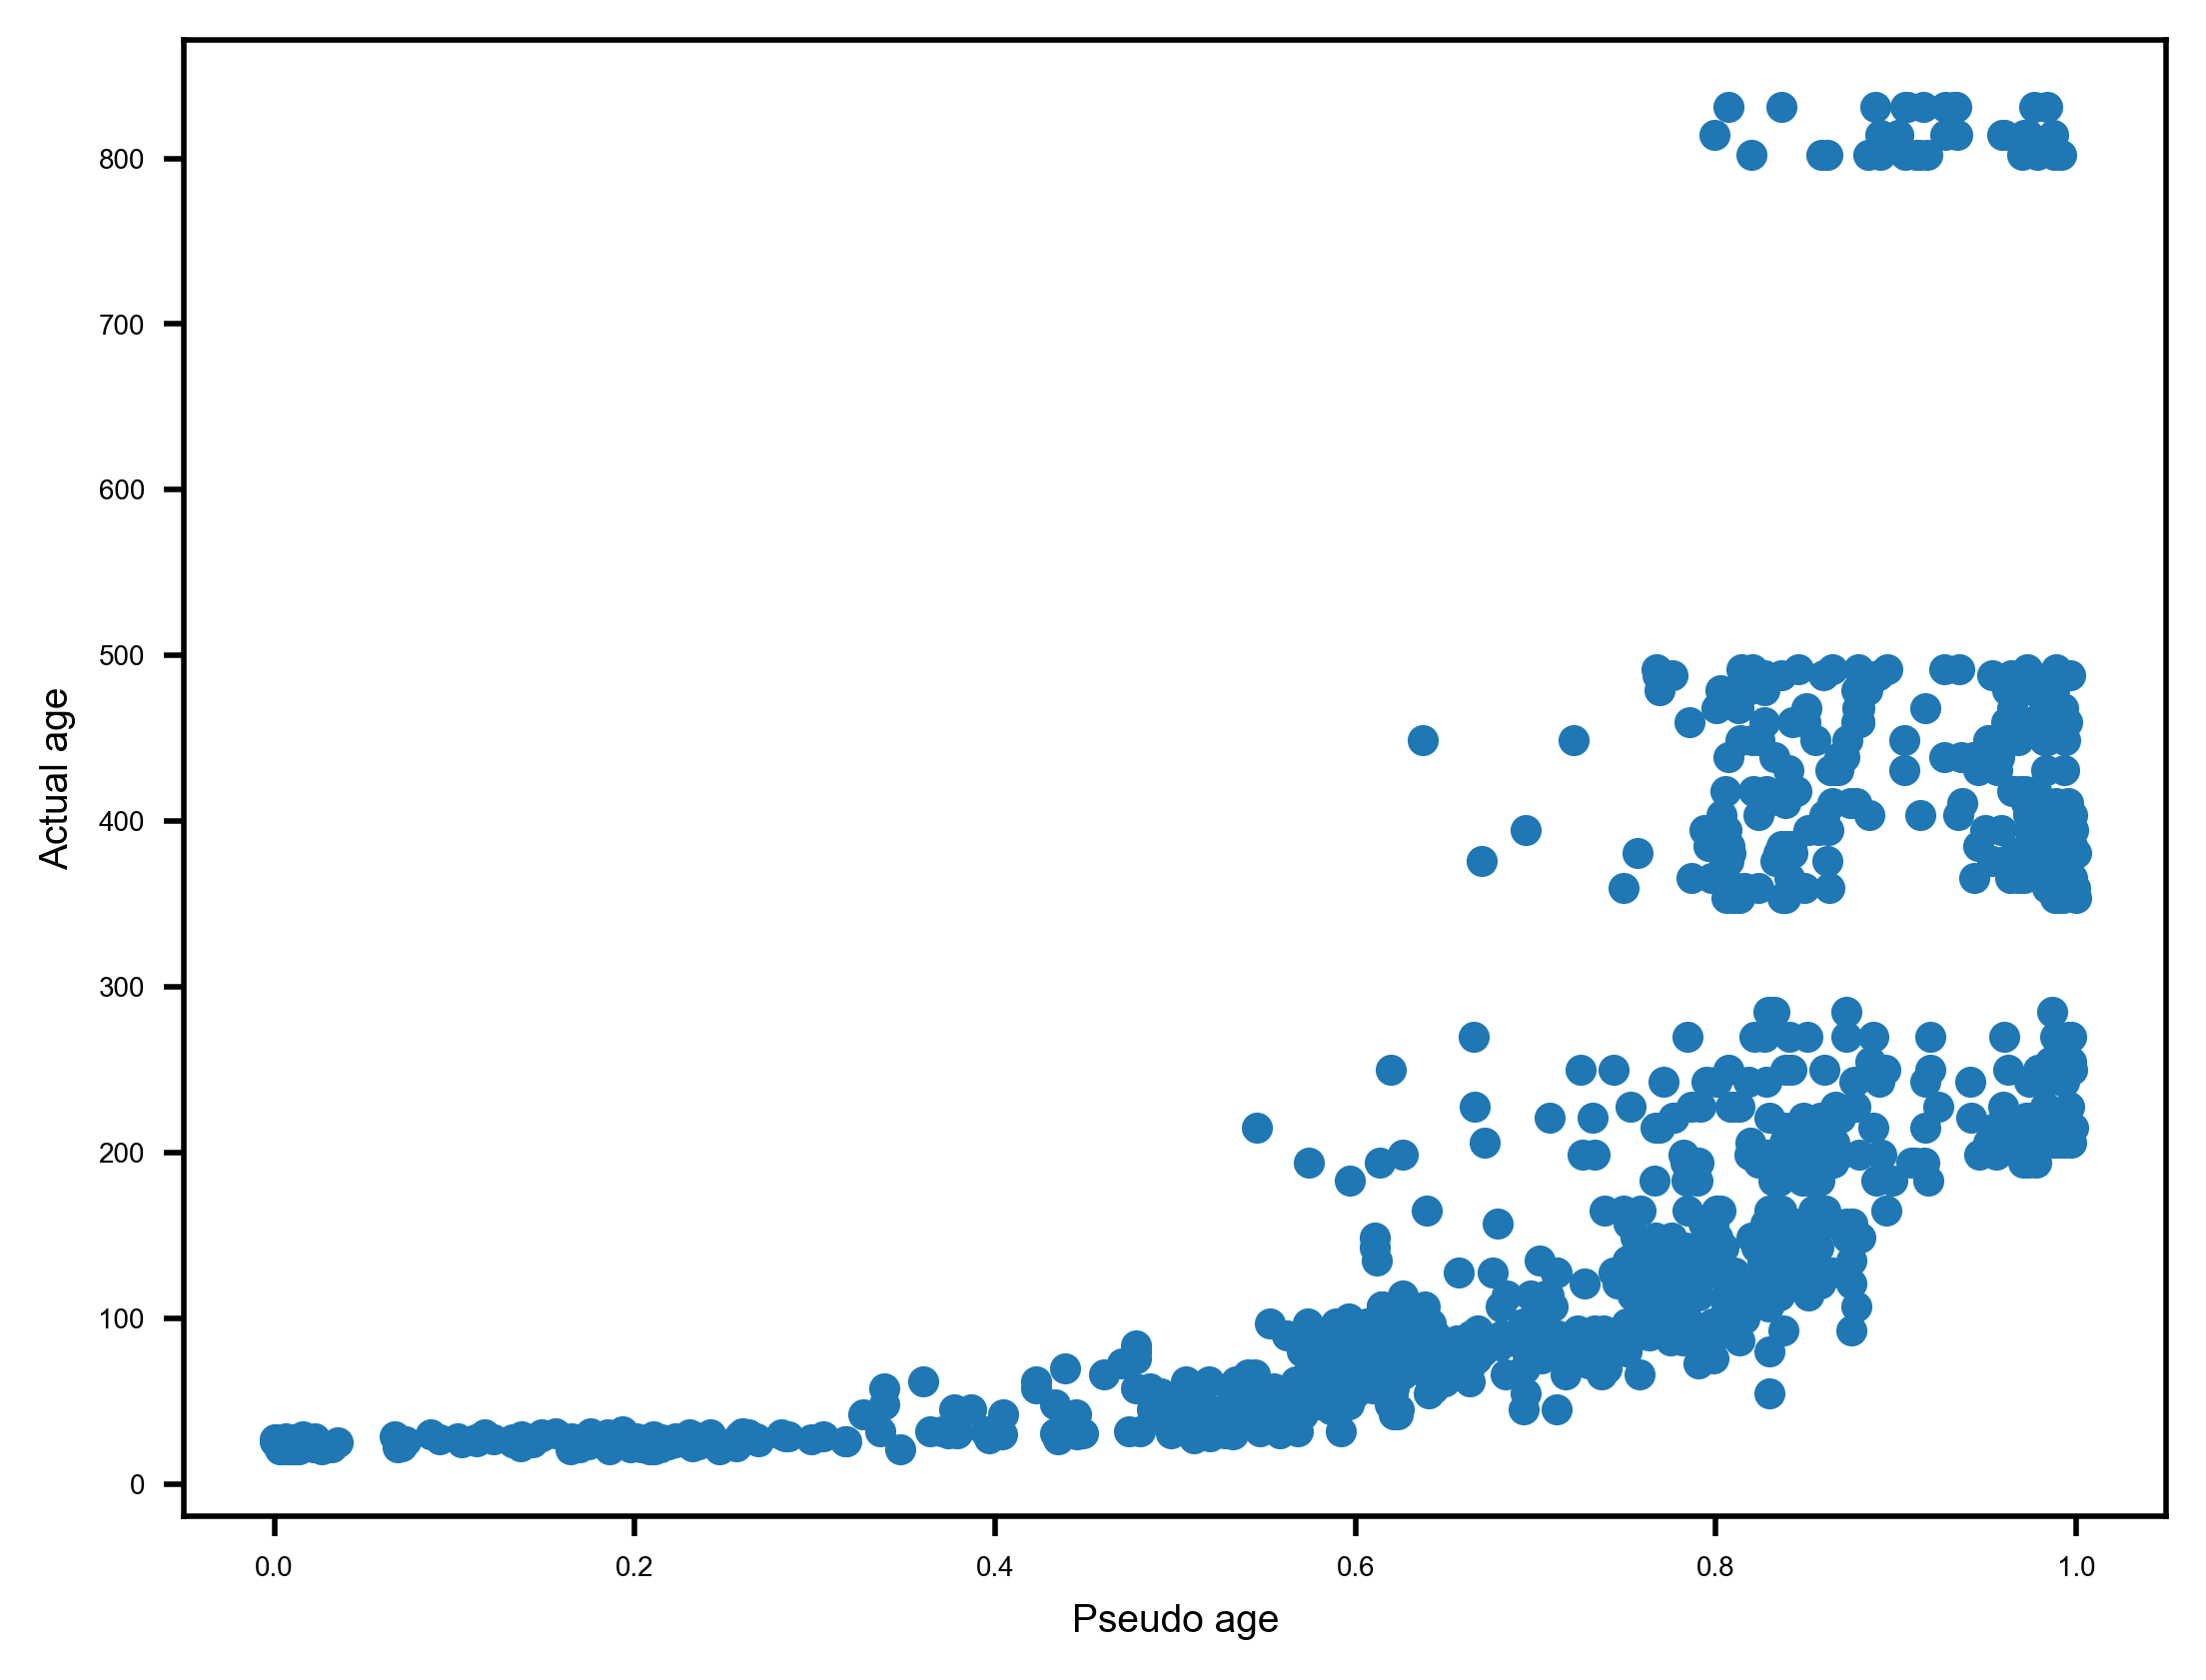

In [30]:
plt.scatter(1 - out[:, -1], df.index.get_level_values('age'))
plt.xlabel('Pseudo age')
plt.ylabel("Actual age")
print(spearmanr(1 - out[:, -1], df.index.get_level_values('age')))

In [31]:
enc = LabelEncoder().fit(df.index.get_level_values('mouse'))

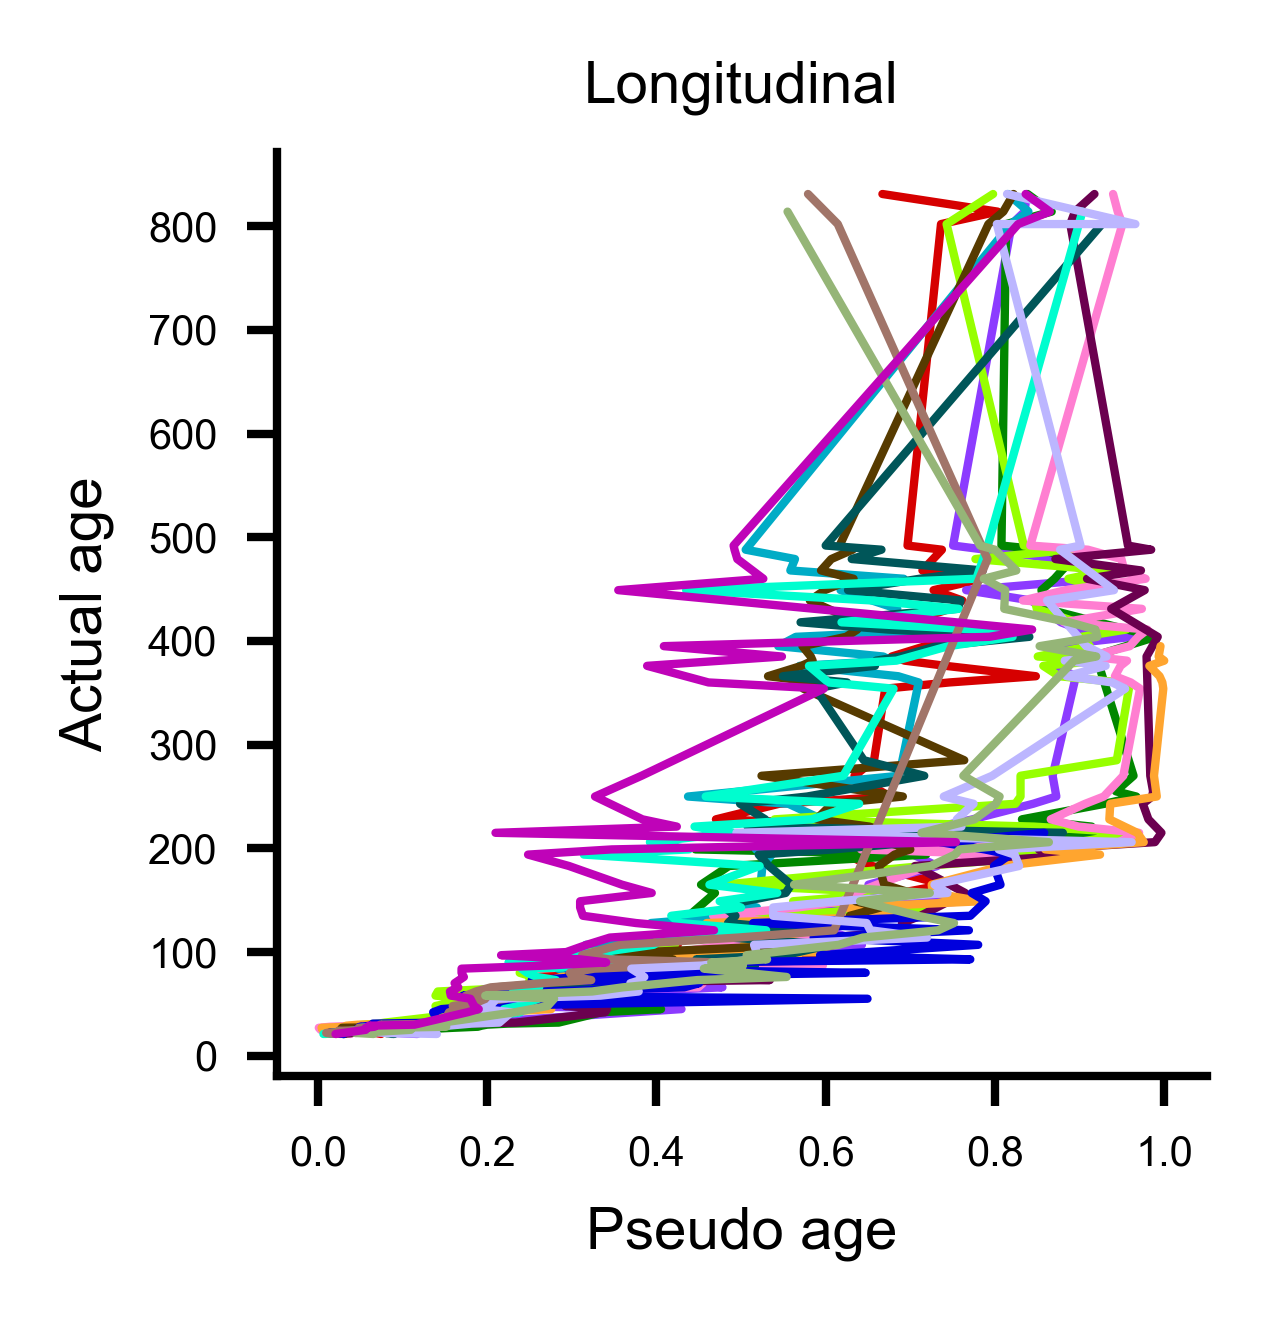

In [32]:
new_ser = pd.Series(rank_frac, index=df.index)
# new_ser = pd.Series(1 - out[:, -1], index=df.index)

figure(2, 2)
for mouse, s in new_ser.groupby('mouse'):
    l = enc.transform([mouse])[0]
    plt.plot(s, s.index.get_level_values('age'), c=cc.glasbey[l])

plt.xlabel('Pseudo age')
plt.ylabel("Actual age")
plt.title('Longitudinal')
sns.despine()

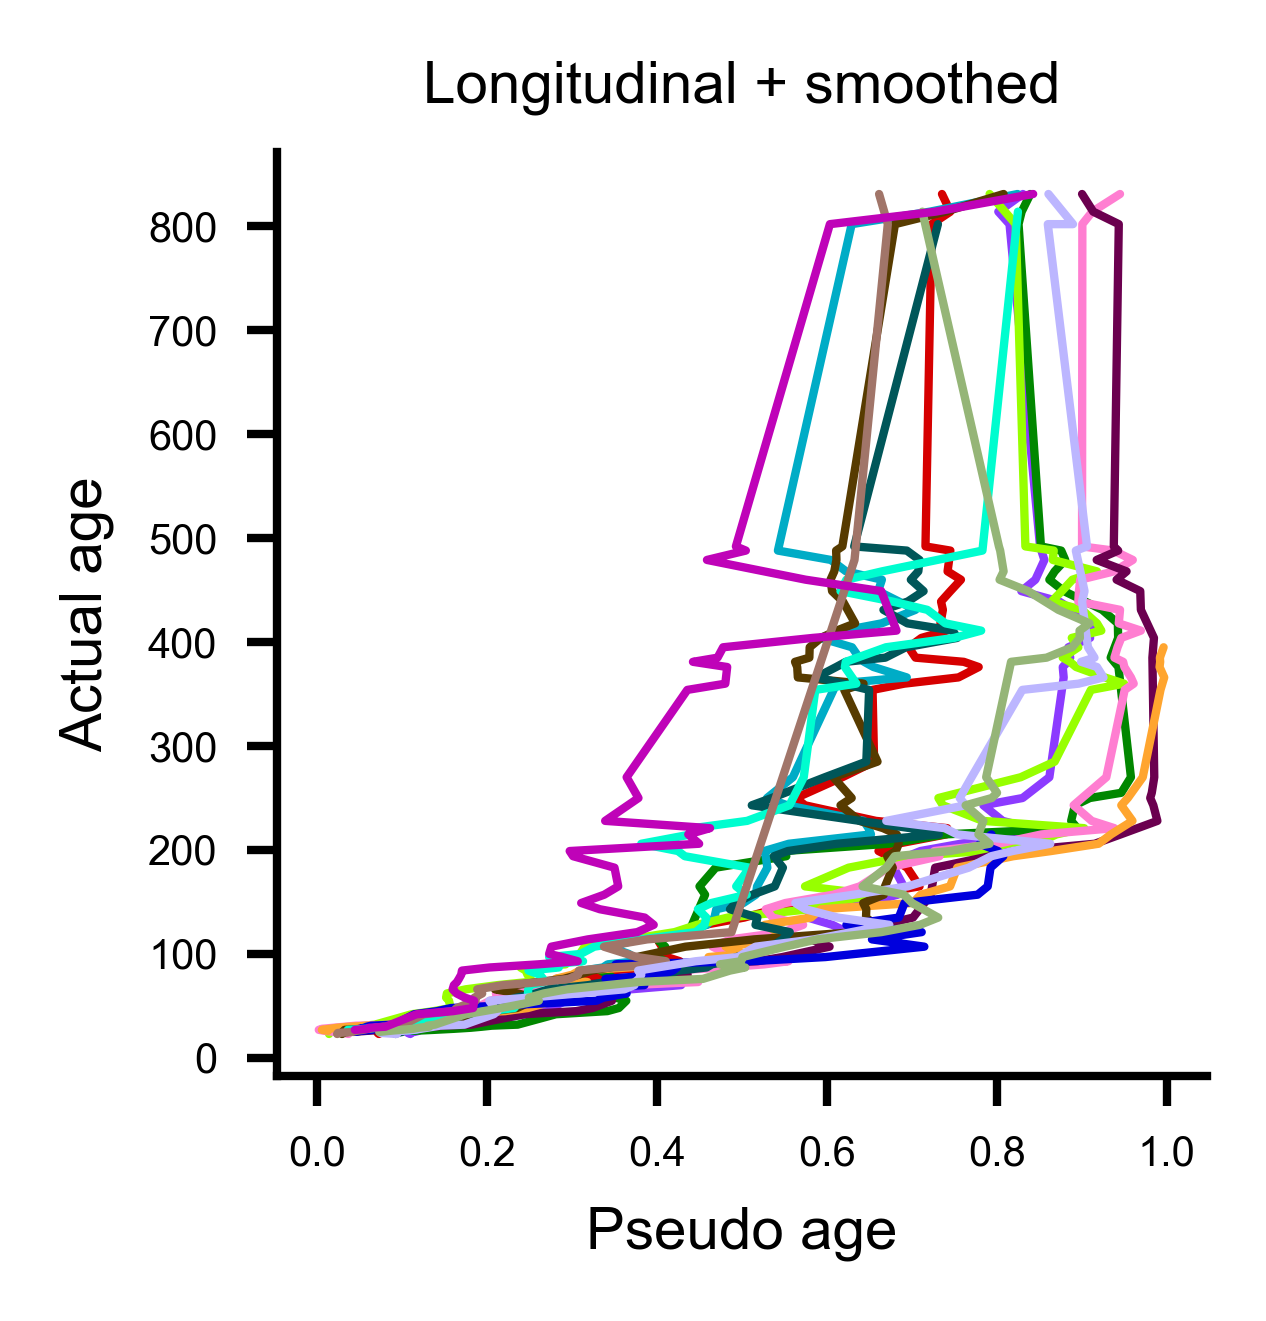

In [82]:
new_ser = pd.Series(rank_frac, index=df.index)
# new_ser = pd.Series(1 - out[:, -1], index=df.index)

figure(2, 2)
for mouse, s in new_ser.groupby('mouse'):
    l = enc.transform([mouse])[0]
    plt.plot(s.rolling(3).mean(), s.index.get_level_values('age'), c=cc.glasbey[l])

plt.xlabel('Pseudo age')
plt.ylabel("Actual age")
plt.title('Longitudinal + smoothed')
sns.despine()

In [83]:
# color by death
dead = [
    '02_04',
    '03_02',
    '03_03',
    '04_01',
    '02_03',
]

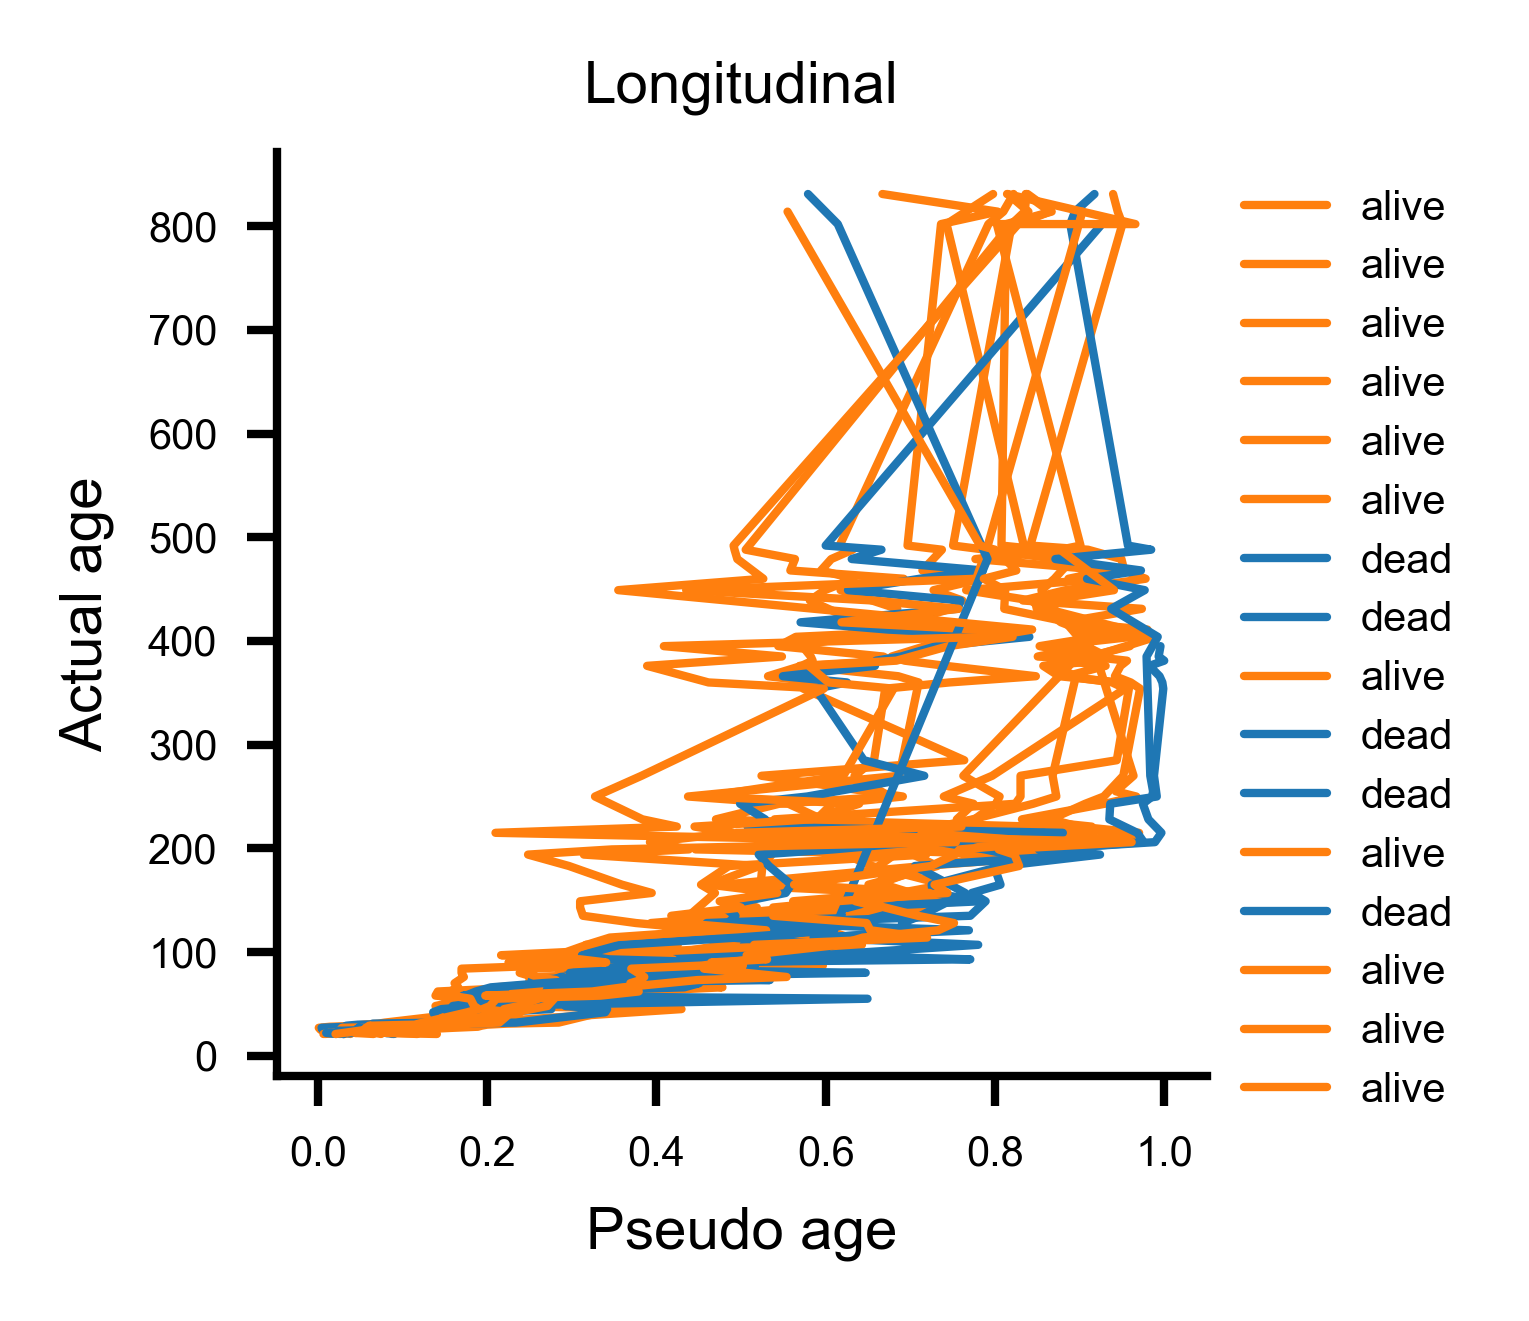

In [84]:
new_ser = pd.Series(rank_frac, index=df.index)
# new_ser = pd.Series(1 - out[:, -1], index=df.index)

figure(2, 2)
for mouse, s in new_ser.groupby('mouse'):
    l = enc.transform([mouse])[0]
    is_dead = mouse in dead
    label = 'dead' if is_dead else 'alive'
    plt.plot(s, s.index.get_level_values('age'), c='C0' if is_dead else 'C1', label=label)

legend()
plt.xlabel('Pseudo age')
plt.ylabel("Actual age")
plt.title('Longitudinal')
sns.despine()

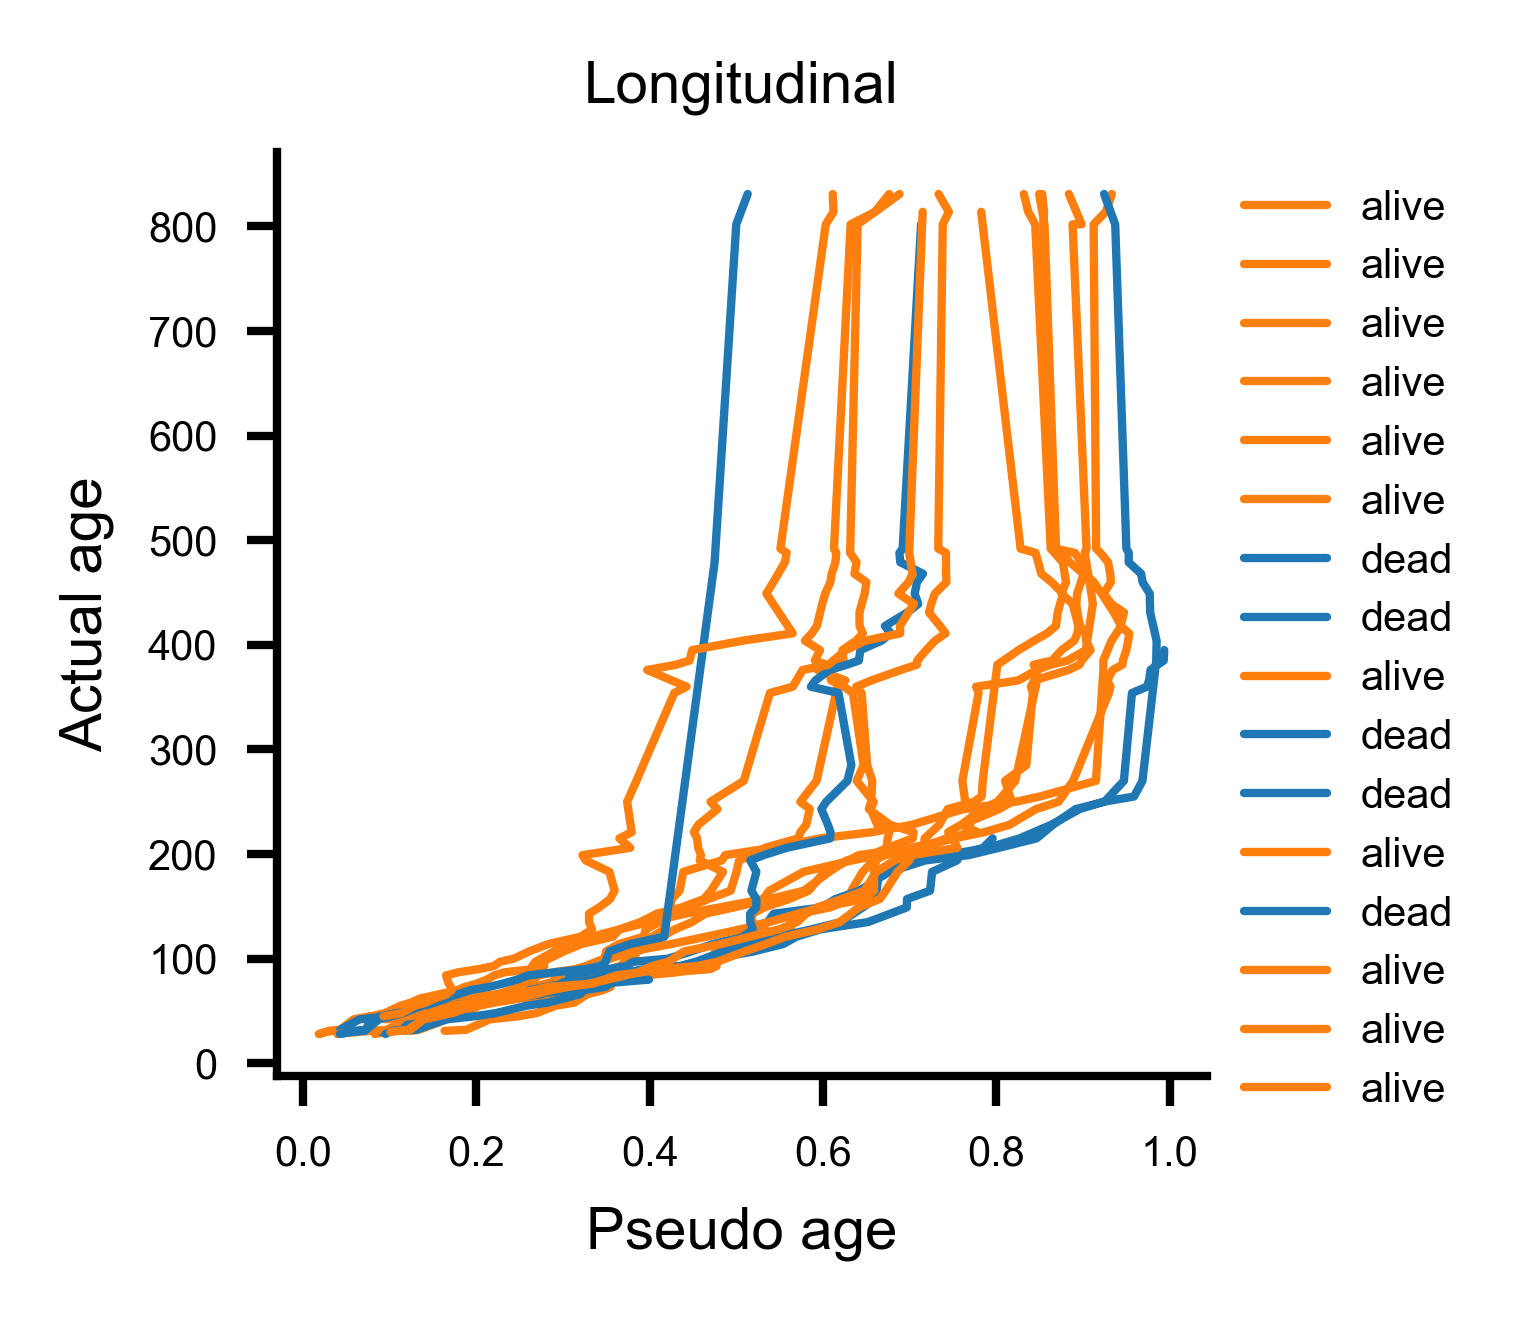

In [85]:
new_ser = pd.Series(rank_frac, index=df.index)
# new_ser = pd.Series(1 - out[:, -1], index=df.index)

figure(2, 2)
for mouse, s in new_ser.groupby("mouse"):
    l = enc.transform([mouse])[0]
    is_dead = mouse in dead
    label = "dead" if is_dead else "alive"
    plt.plot(
        s.rolling(8).mean(),
        s.index.get_level_values("age"),
        c="C0" if is_dead else "C1",
        label=label,
    )

legend()
plt.xlabel("Pseudo age")
plt.ylabel("Actual age")
plt.title("Longitudinal")
sns.despine()

In [77]:
df.iloc[0].name[1]

'01_01'

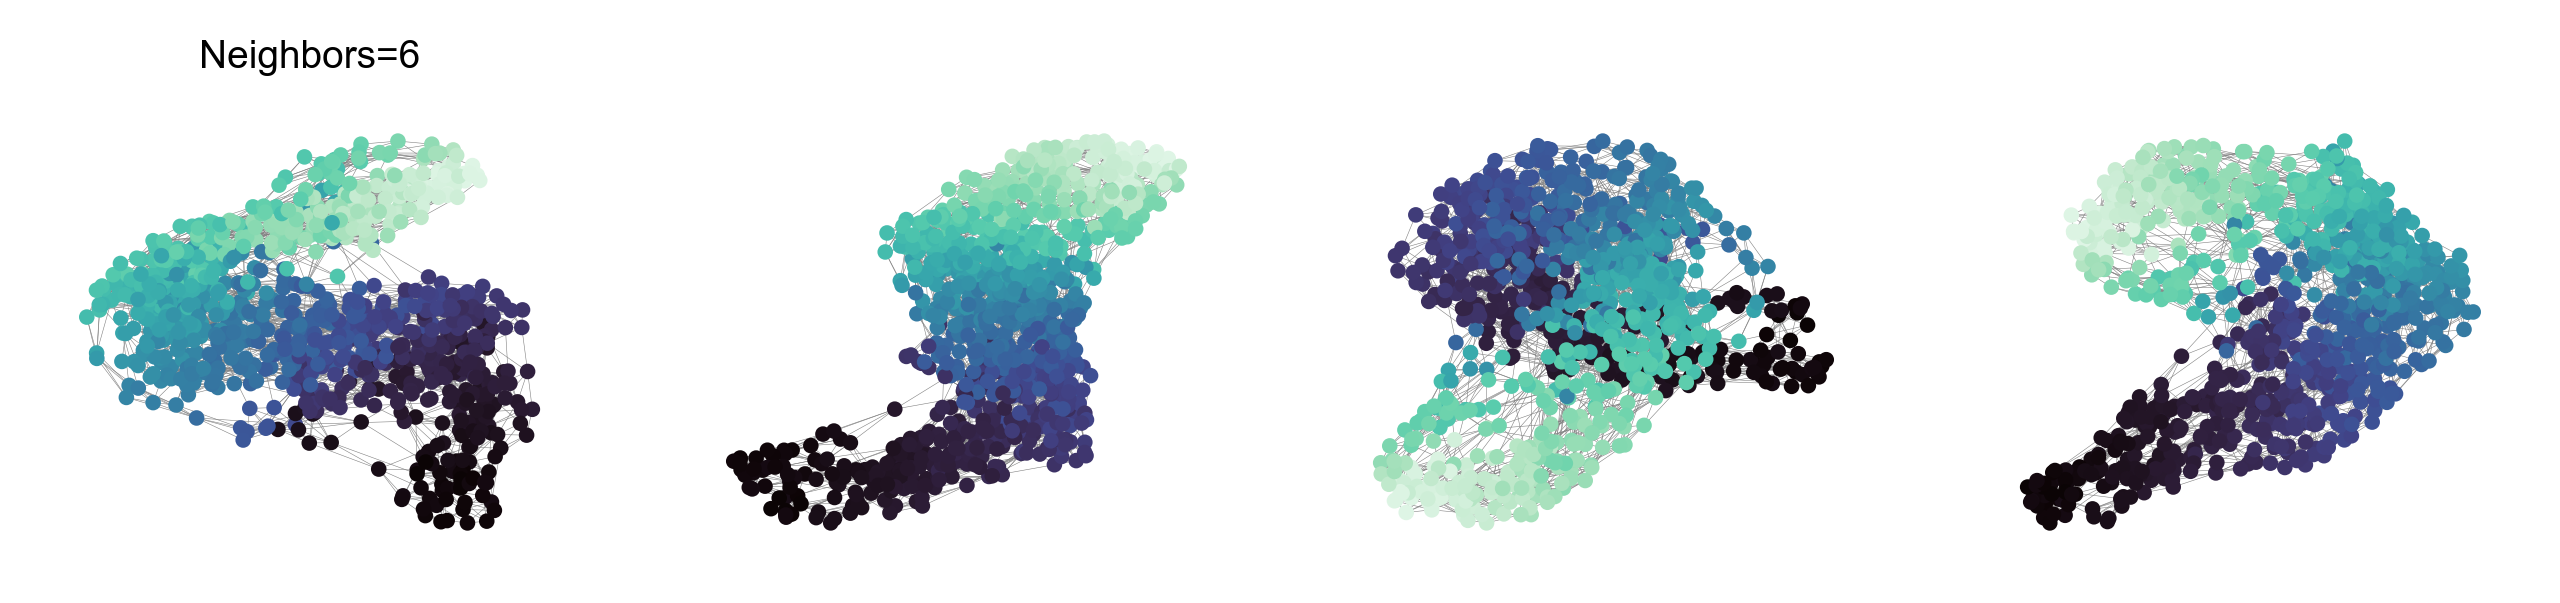

In [33]:
width = 2
n_cols = 4
indices = nn[:, :k_neigh + 1]

graph = nx.Graph()
edges = []
for row in indices:
    i = row[0]
    for j in row[1:]:
        edges.append((i, j, distances[i, j]))
graph.add_weighted_edges_from(edges)
# colors = [1 - out[i, -1] for i in graph.nodes]
colors = [rank_frac[i] for i in graph.nodes]

fig, ax = plt.subplots(1, n_cols, figsize=(n_cols * width, 1.5))
for i, a in enumerate(ax.flat):
    pos = nx.spring_layout(graph, seed=i)
    nx.draw(
        graph,
        pos=pos,
        node_size=4,
        width=0.1,
        edge_color="gray",
        node_color=colors,
        arrows=False,
        ax=a,
        cmap="mako",
    )
ax[0].set(title=f"Neighbors={k_neigh}")
plt.show()

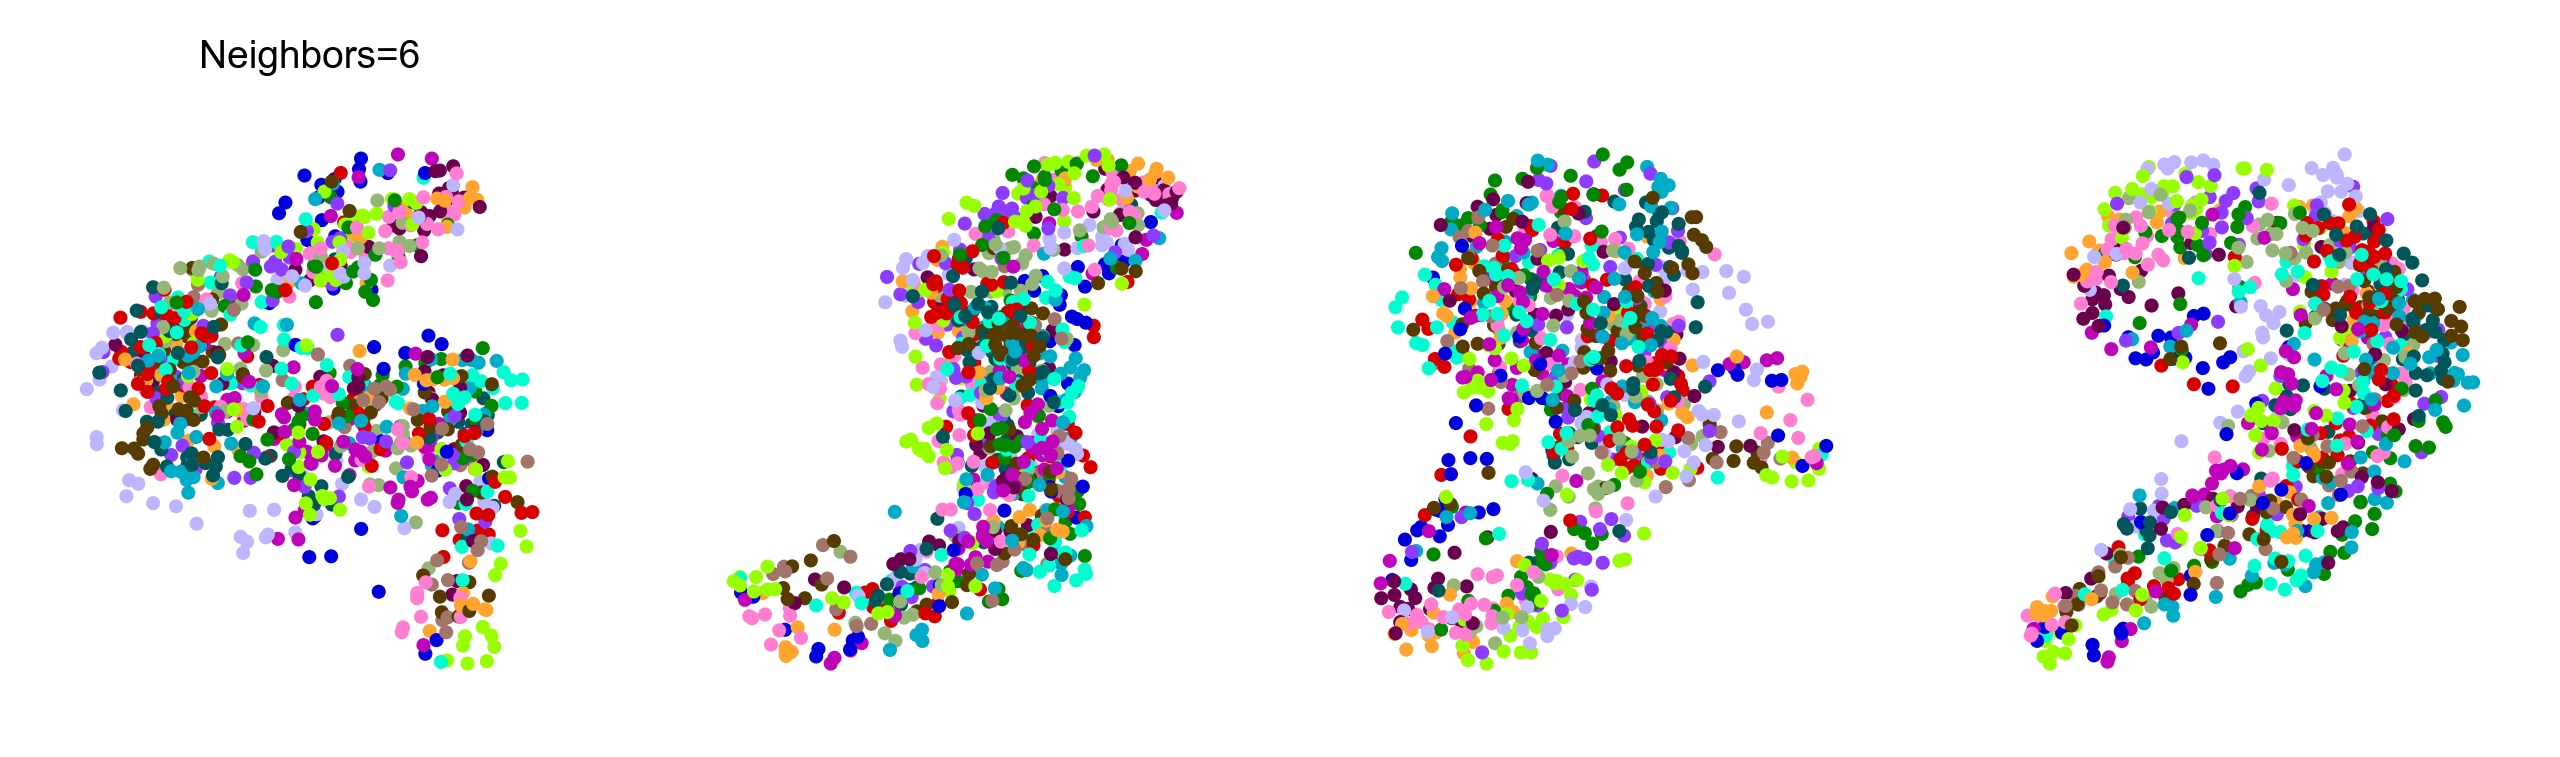

In [34]:
width = 2
n_cols = 4
indices = nn[:, :k_neigh + 1]

graph = nx.Graph()
edges = []
for row in indices:
    i = row[0]
    for j in row[1:]:
        edges.append((i, j, distances[i, j]))
graph.add_weighted_edges_from(edges)
# colors = [1 - out[i, -1] for i in graph.nodes]
colors = [cc.glasbey[enc.transform([mouse])[0]] for mouse in map(lambda i: df.iloc[i].name[1], graph.nodes)]
fig, ax = plt.subplots(1, n_cols, figsize=(n_cols * width, 2))
for i, a in enumerate(ax.flat):
    pos = nx.spring_layout(graph, seed=i)
    nx.draw(
        graph,
        pos=pos,
        node_size=3,
        width=0,
        edge_color="gray",
        node_color=colors,
        arrows=False,
        ax=a,
    )
ax[0].set(title=f"Neighbors={k_neigh}")
plt.show()

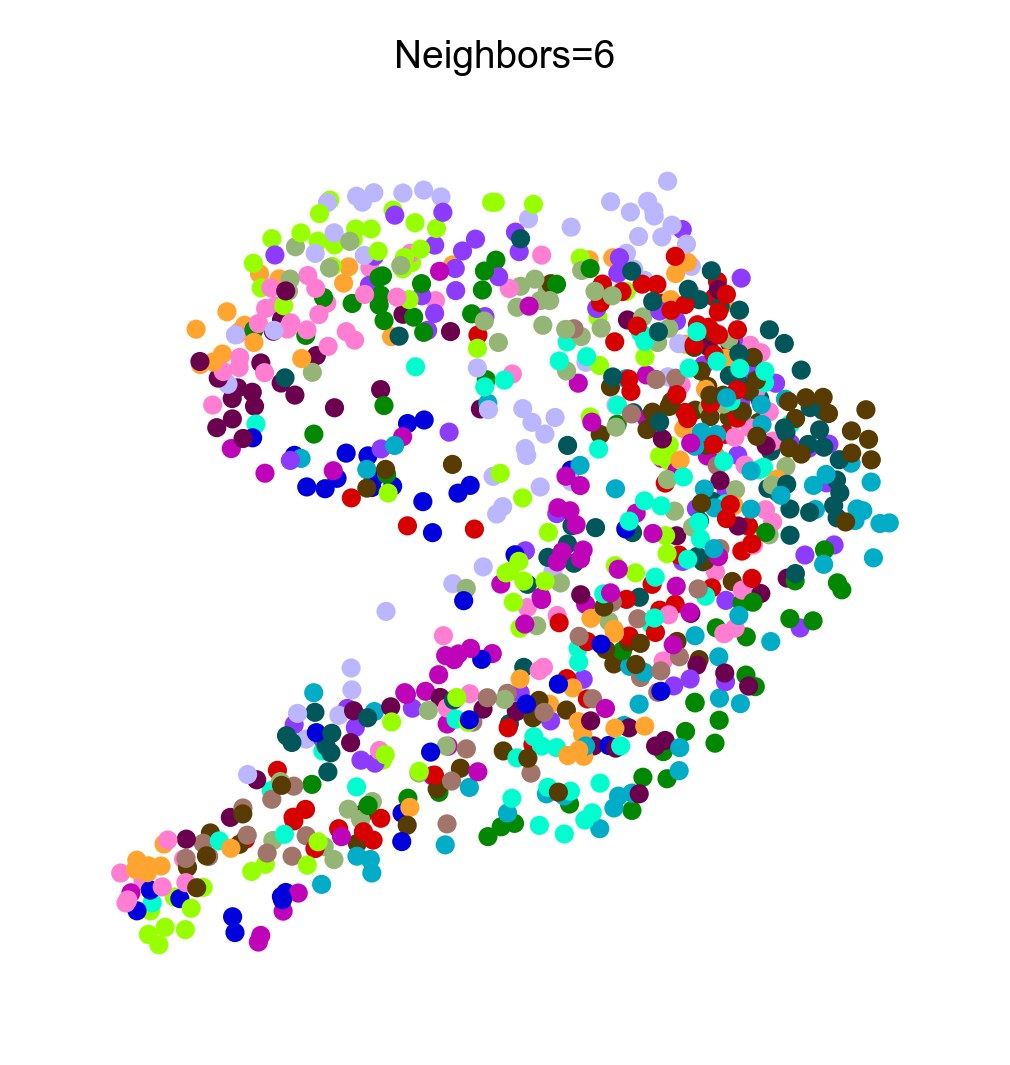

In [36]:
width = 3
indices = nn[:, :k_neigh + 1]

graph = nx.Graph()
edges = []
for row in indices:
    i = row[0]
    for j in row[1:]:
        edges.append((i, j, distances[i, j]))
graph.add_weighted_edges_from(edges)
# colors = [1 - out[i, -1] for i in graph.nodes]
colors = [cc.glasbey[enc.transform([mouse])[0]] for mouse in map(lambda i: df.iloc[i].name[1], graph.nodes)]
fig, ax = plt.subplots(1, 1, figsize=(width, width))
pos = nx.spring_layout(graph, seed=3)
nx.draw(
    graph,
    pos=pos,
    node_size=7,
    width=0,
    edge_color="gray",
    node_color=colors,
    arrows=False,
    ax=ax,
)
ax.set(title=f"Neighbors={k_neigh}")
plt.show()

In [38]:
correlations = []
for k_neigh in trange(4, 16):
    a = np.zeros_like(distances)
    a[np.arange(len(a))[:, None], nn[:, :k_neigh + 1]] = 1 / k_neigh

    beta = 0.1
    smoother = np.eye(len(a)) * beta * a + (1 - beta) * a

    seed_idx = np.where(df.index.get_level_values('age') == df.index.get_level_values('age').min())[0]

    # pseudo_vals = np.zeros(len(a))
    # pseudo_vals[seed_idx] = 1
    pseudo_vals = 1 - _age.copy()

    n_iter = 5_000
    out = pseudo_vals.copy()

    for i in range(1, n_iter):
        out = mm_norm(smoother @ out)

    ranks = rankdata(1 - out)
    rank_frac = ranks / ranks.max()
    sr = spearmanr(rank_frac, df.index.get_level_values('age'))
    correlations.append(sr.statistic)
    print(k_neigh, spearmanr(rank_frac, df.index.get_level_values('age')))

  0%|          | 0/12 [00:00<?, ?it/s]

4 SignificanceResult(statistic=0.811892097901207, pvalue=1.9315555300491113e-214)
5 SignificanceResult(statistic=0.8756933676479958, pvalue=2.489830374291454e-289)
6 SignificanceResult(statistic=0.8809131474252427, pvalue=3.042907455107837e-297)
7 SignificanceResult(statistic=0.8765528755688359, pvalue=1.312277255196222e-290)
8 SignificanceResult(statistic=0.8795909003564136, pvalue=3.3299458182944086e-295)
9 SignificanceResult(statistic=0.8765962654523975, pvalue=1.1304428432936135e-290)
10 SignificanceResult(statistic=0.8778729075525383, pvalue=1.3687155068567906e-292)
11 SignificanceResult(statistic=0.8790925808402614, pvalue=1.9262615143646443e-294)
12 SignificanceResult(statistic=0.880055384433909, pvalue=6.439681298173215e-296)
13 SignificanceResult(statistic=0.8788327041466844, pvalue=4.796362235979507e-294)
14 SignificanceResult(statistic=0.8796006330693606, pvalue=3.217476565867572e-295)
15 SignificanceResult(statistic=0.8801561726823759, pvalue=4.504382417382706e-296)


In [39]:
np.argmax(correlations)

2

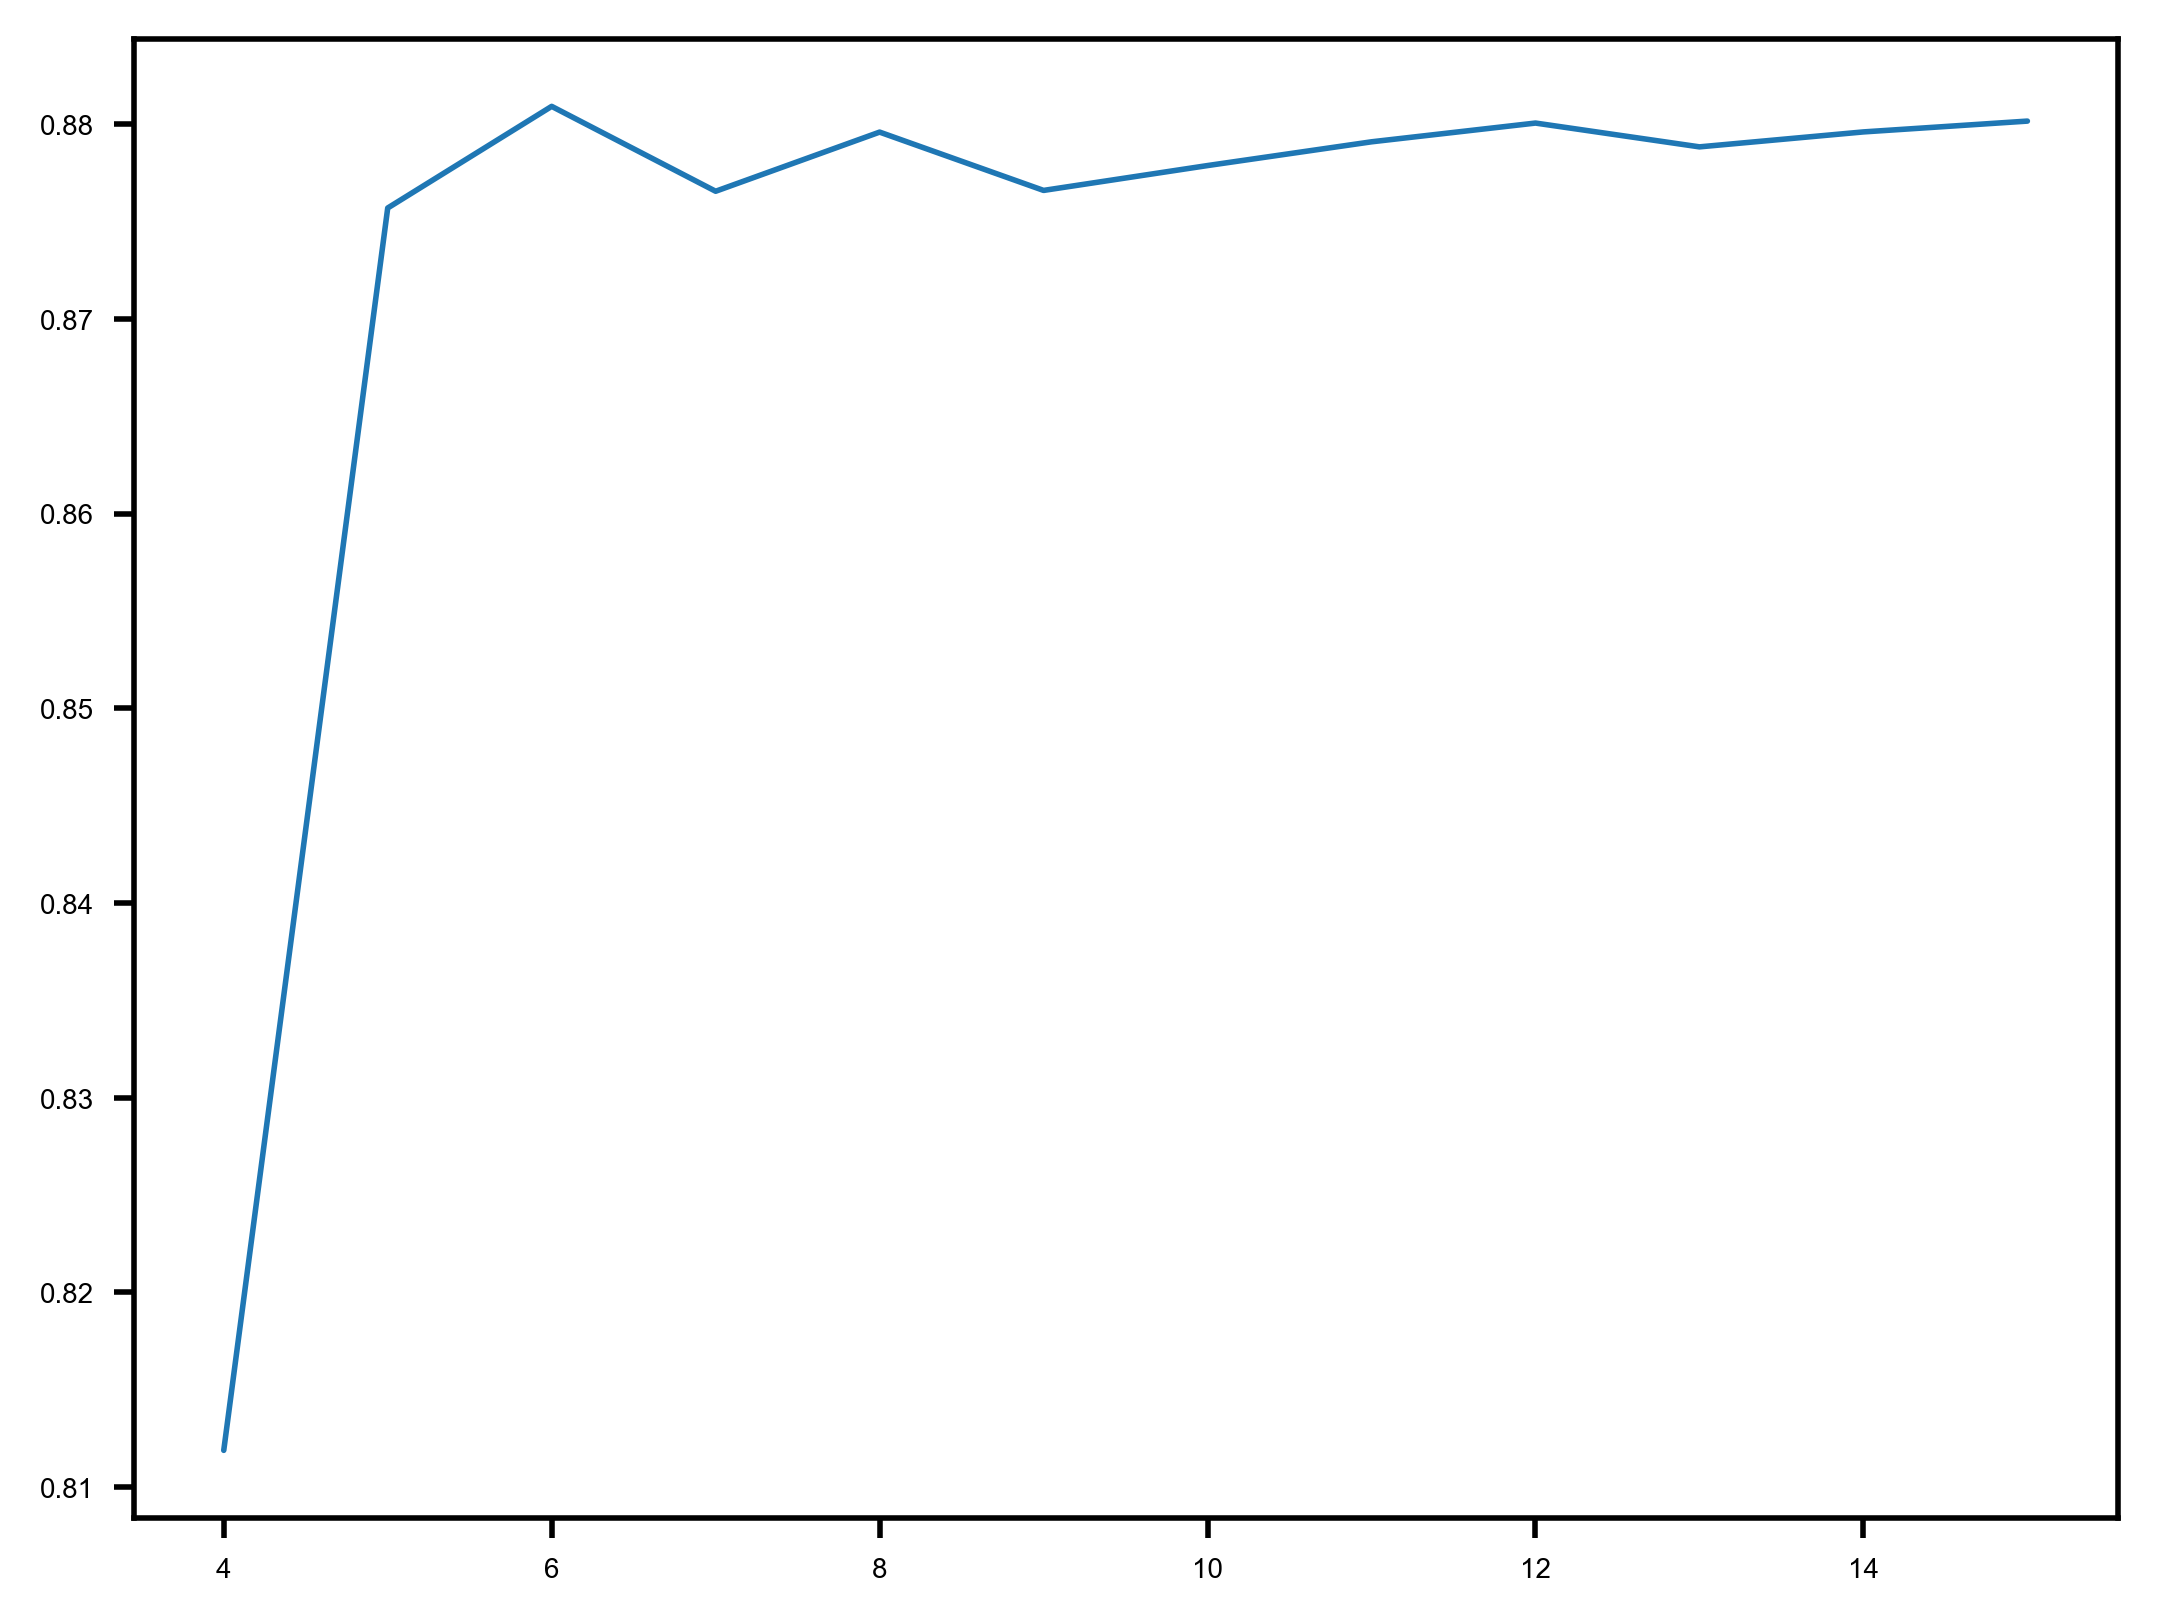

In [40]:
plt.plot(range(4, 16), correlations)